In [1]:
!date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi']=300

import sys
sys.path.append('kspaces')

import kspaces.EM
import kspaces.plotting
import kspaces.generate
import kspaces.affine_subspace_

Mon Dec  1 15:48:55 PST 2025


This notebook has examples of:

- generating synthetic data
- fitting a model
- assigning new points to existing subspaces after a model has been fit
- constructing affine_subspace objects directly
- model selection

and explanations for:

- kspaces.EM.run_EM
- kspaces.EM.E_step
- kspaces.EM.fit_single_space
- kspaces.affine_subspace_.affine_subspace
- kspaces.affine_subspace_.fixed_space
- kspaces.generate.generate_points_subspace
- kspaces.generate.generate
- kspaces.model_selection

A plotting function

In [2]:
def plot_3D(points,spaces, axis_labels = ('','',''),title = '', equal_dims = True, color_probabilities = [], f = '', el = 70, az = 20, sd_length = None):
    """create a 3D plot with matplotlib"""
    # Create figure and subplots
    fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': '3d'})
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    
    colors = np.array(['crimson', 'blue', 'darkorange', 'green', 'violet','brown'])
    
    xlim = [min(x), max(x)]
    ylim = [min(y), max(y)]
    zlim = [min(z),max(z)]
    
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_title(title)
    

    #plot points
    ax.scatter(x, y, z, color=kspaces.plotting.color_by_cluster(color_probabilities), marker='o', alpha = 1, s = 1)

    if equal_dims:
        ax.set_aspect('equal')
    #plot the fitted spaces
    for idx, space in enumerate(spaces):
        c = colors[idx%len(colors)]
        style = '-'
        if space.d == 0:
            kspaces.plotting.plot_point_3D(ax, xlim, ylim, zlim, space, color=c)
        elif space.d == 1:
            kspaces.plotting.plot_line_3D(ax, xlim, ylim, zlim, space, color=c, linestyle=style, sd_length = sd_length)
        elif space.d ==2:
            kspaces.plotting.plot_plane(ax, xlim, ylim, zlim, space, color=c)

    # Set different viewing angles
    ax.view_init(elev=el, azim=az)


    # Adjust layout and display

    if f != '':
        plt.savefig(f)
    plt.show()

In [3]:
plt.rcParams['grid.color'] = "lightgray"

# Generate a toy dataset

kspaces.generate.generate_points_subspace() accepts vectors and a single, isotropic within subspace standard deviation for latent points and a single, isotropic standard deviation for noise. It is a quick way to generate synthetic data. kspaces.generate.generate() accepts a list of k-spaces affine subspaces and offers more flexibility.

In [4]:
np.random.seed(0)

Make a data from 4 subspaces:

In [5]:
t1 = [2,2,0]
v1 = [[1,0,0],[0,1,0.3]]
X1 = kspaces.generate.generate_points_subspace(t1, v1, 4000, dist_std = 4, noise_std=0.1)
s1 = kspaces.affine_subspace_.affine_subspace(v1, t1, 0.1, [3,3], 0)
c1 =[[1,0,0,0]]*4000

In [6]:
t2 = [0,6,6]
v2 = [[1,1,1]]
X2 = kspaces.generate.generate_points_subspace(t2, v2, 200, dist_std = 6, noise_std=0.1)
s2 = kspaces.affine_subspace_.affine_subspace(v2, t2, 0.1, [3], 0)
c2 = [[0,1,0,0]]*200

In [7]:
t3 = [7,-8,9]
v3 = []
X3 = kspaces.generate.generate_points_subspace(t3, v3, 100, dist_std = 3, noise_std=2)
s3 = kspaces.affine_subspace_.affine_subspace(v3, t3, 0.5, [], 0)
c3 = [[0,0,1,0]]*100

In [8]:
t4 = [0,6,3]
v4 = [[-1,1,3]]
X4 = kspaces.generate.generate_points_subspace(t4, v4, 300, dist_std = 5, noise_std=1)
s4 = kspaces.affine_subspace_.affine_subspace(v4, t4, 0.4, [5], 0)
c4 = [[0,0,0,1]]*300

**Show ground truth data**

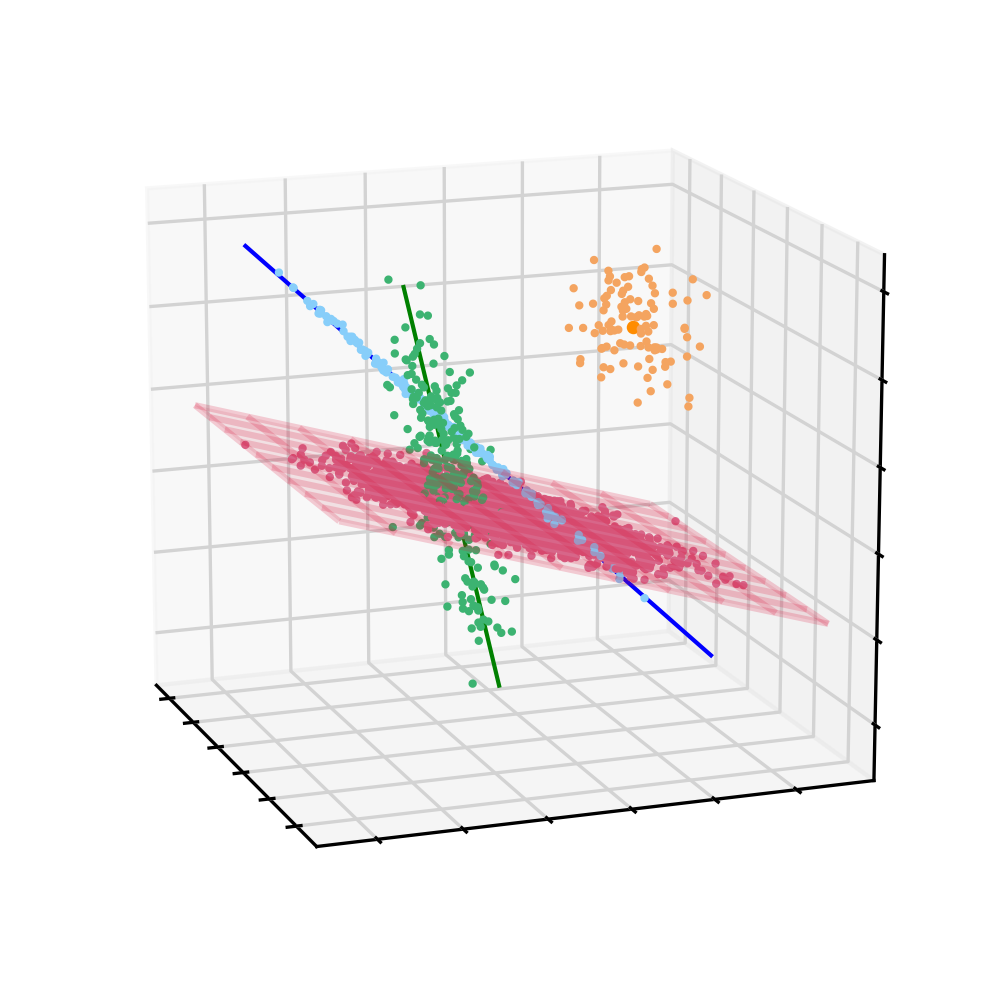

In [9]:
X = np.concatenate([X1,X2,X3,X4], axis = 0)
plot_3D(X, [s1,s2,s3,s4], color_probabilities = np.concatenate([c1,c2,c3,c4], axis = 0), el = 15, az = 160)

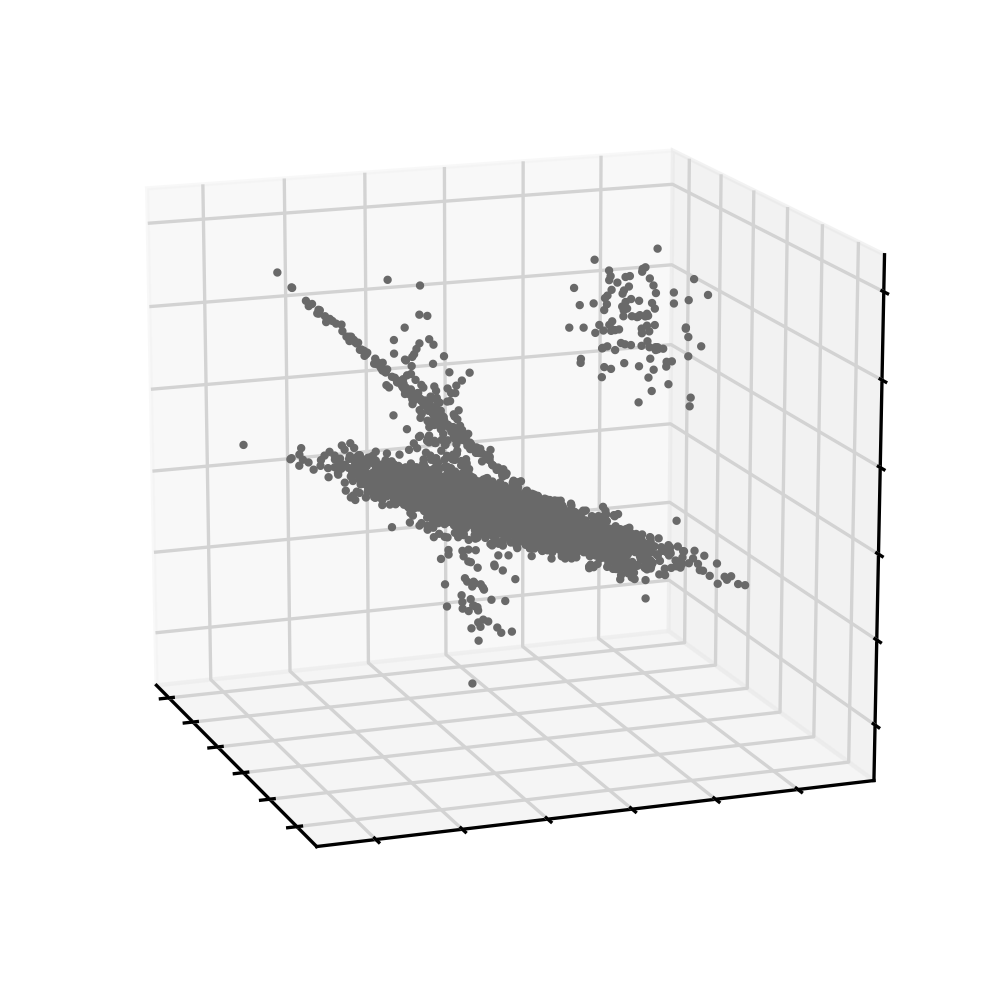

In [10]:
X = np.concatenate([X1,X2,X3,X4], axis = 0)
plot_3D(X, [], color_probabilities = [], el = 15, az = 160)

# Fit a model

**run_EM** is the general all-purpose wrapper for fitting models with k-spaces. It takes in data and model hyperparameters and returns a k-spaces model (a list of fitted subspaces and their probability distributions) and a matrix of probabilistic assignments of points to subspaces.

The only required arguments are '**points**' (the data) and '**kd**' (a list of length k, where each entry specifies the dimension of a subspace), but '**assignment**', '**max_iter**', '**tol**', and '**intializations**' should be chosen based on context too. 

'**fixed_spaces**' or '**init_spaces**' are useful in some contexts, as is '**DA**' (deterministic annealing), though these are more advanced options. 

'**fixed_spaces**' is a list of '**fixed_space**' objects, which inherit the properties of the '**affine_subspace**' class but their M-step does not adjust the basis vectors or translation for the subspace (i.e., the subspace is 'fixed'). The probability distribution-related parameters do get updated in the EM process though. '**init_spaces**' is a list specifying a starting k-spaces model to do an EM initialization with. It overrides '**kd**', but random initialiations will follow and the best model will be returned if '**intializations**' is not set to 1. '**DA**' and the '**beta**' and '**anneal_rate**' arguments are for deterministic annlealing, which can improve chances of finding the global optimal solution but is slower because EM must be reinitialized more times. (Naonori Ueda and Ryohei Nakano. Deterministic annealing EM algorithm. Neural Networks, 11(2):271–282, March 1998.)

Converged on iteration 24
Converged on iteration 18
Converged on iteration 8
Converged on iteration 13
Converged on iteration 27
Converged on iteration 19
Failed on iteration 10: a space was eliminated
Converged on iteration 46
Converged on iteration 12
Converged on iteration 25
time per EM run: 0.08
time per E, M step : [0.0011 0.0026]


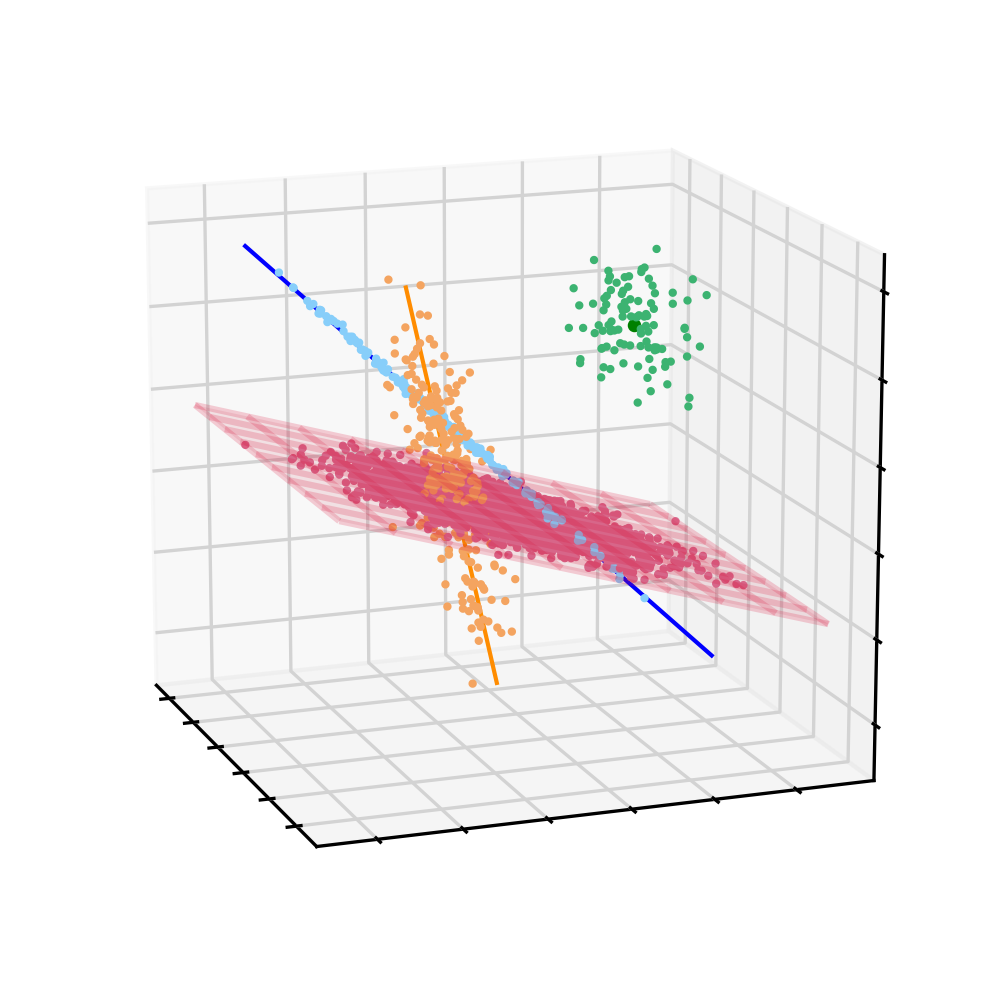

In [11]:
spaces_correct, probabilities = kspaces.EM.run_EM(X, [2,1,1,0], max_iter = 50, initializations = 10, randomize_init = True)
plot_3D(X, spaces_correct, color_probabilities = probabilities, el = 15, az = 160,)

An affine subspace can be fit individually to data as well using kspaces.EM.fit_single_space, a wrapper for affine_subspace.fit

# Walk through the EM process

This only uses 1 initialization (the default for kspaces.run_EM) so we can isolate the results of each initialization and compare them. In practice, we would never do this as this EM is only guaranteed to converge to local minima.

**seed = 0 and seed = 1 did not converge on the correct solution. Again, in practice we would never use run_EM like this and would always use multiple initializations.** These two examples will be shown below under "other initializations that didn't work"

Initialization

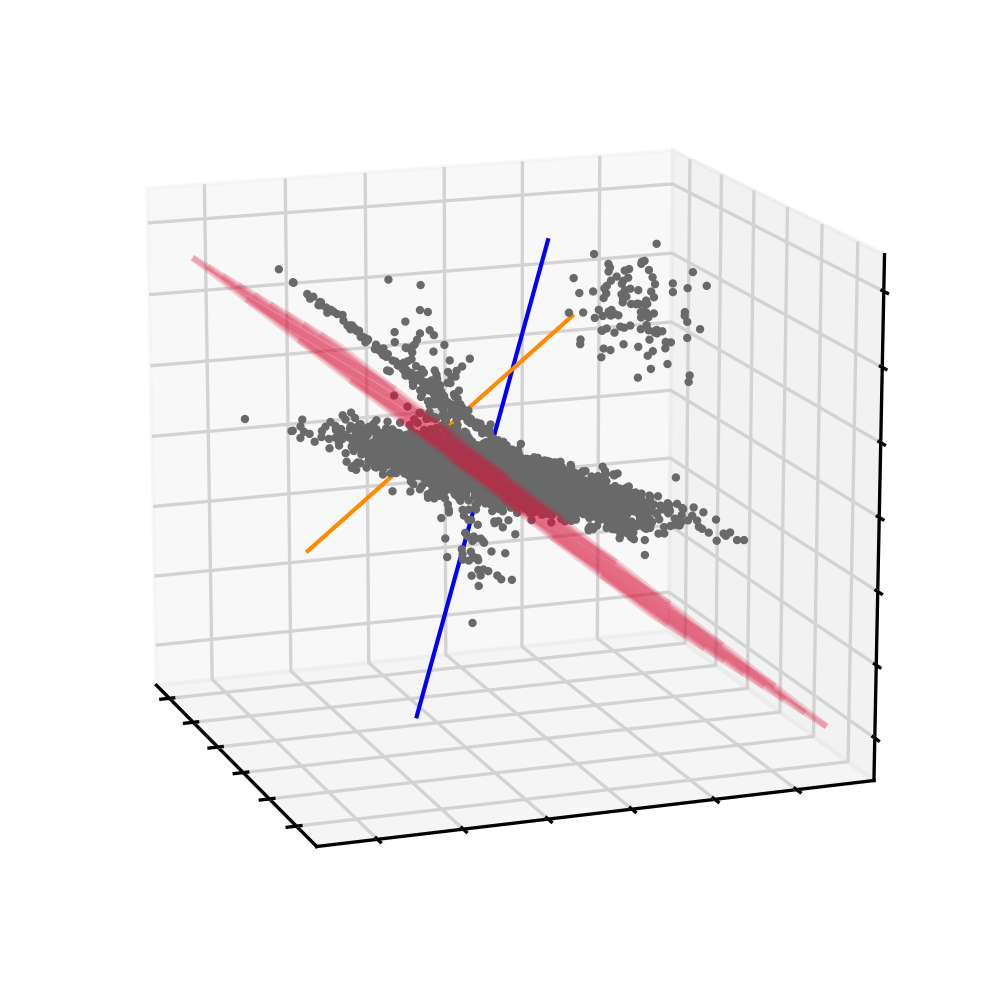

In [12]:
np.random.seed(2)
spaces = kspaces.EM.init(X, D = 3, kd = [2,1,1,0])
probabilities = kspaces.EM.E_step(X, spaces, assignment = 'soft')
plot_3D(X, spaces, color_probabilities = [], el = 15, az = 160)

E step after initialization

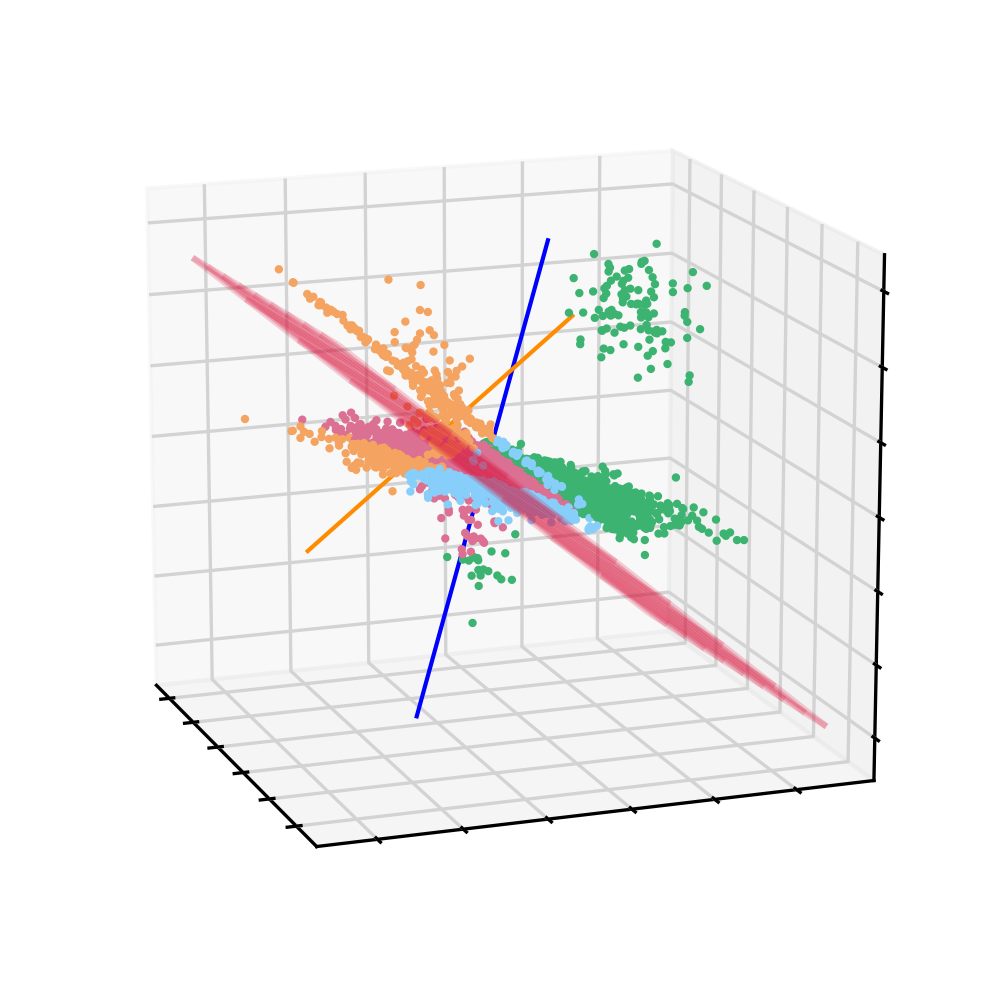

In [13]:
np.random.seed(2)
spaces = kspaces.EM.init(X, D = 3, kd = [2,1,1,0])
probabilities = kspaces.EM.E_step(X, spaces, assignment = 'soft')
plot_3D(X, spaces, color_probabilities = probabilities, el = 15, az = 160)

Max_iter = 1 so we can see how this looked after 1 round of EM.

max iteration 1 completed
max iteration 1 completed
max iteration 1 completed
max iteration 1 completed
max iteration 1 completed
max iteration 1 completed
max iteration 1 completed
max iteration 1 completed
max iteration 1 completed
max iteration 1 completed
time per EM run: 0.005
time per E, M step : [0.0011 0.0028]


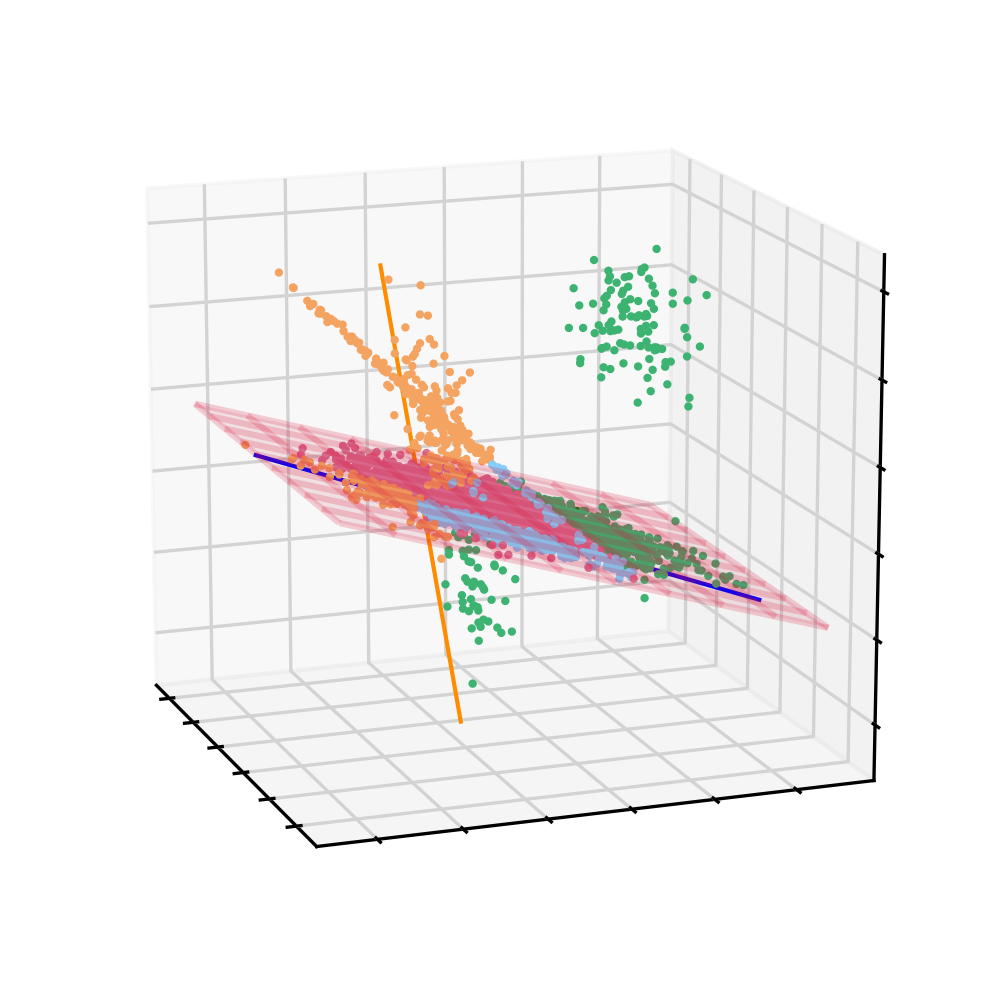

In [14]:
np.random.seed(2)
spaces, probabilities = kspaces.EM.run_EM(X, kd = [2,1,1,0], max_iter = 1, randomize_init = True)
plot_3D(X, spaces, color_probabilities = probabilities, el = 15, az = 160)

Max_iter = 4 (same example) so we can see how this looked after the 4th round of EM.

max iteration 4 completed
max iteration 4 completed
max iteration 4 completed
max iteration 4 completed
max iteration 4 completed
max iteration 4 completed
max iteration 4 completed
max iteration 4 completed
max iteration 4 completed
max iteration 4 completed
time per EM run: 0.017
time per E, M step : [0.0011 0.0027]


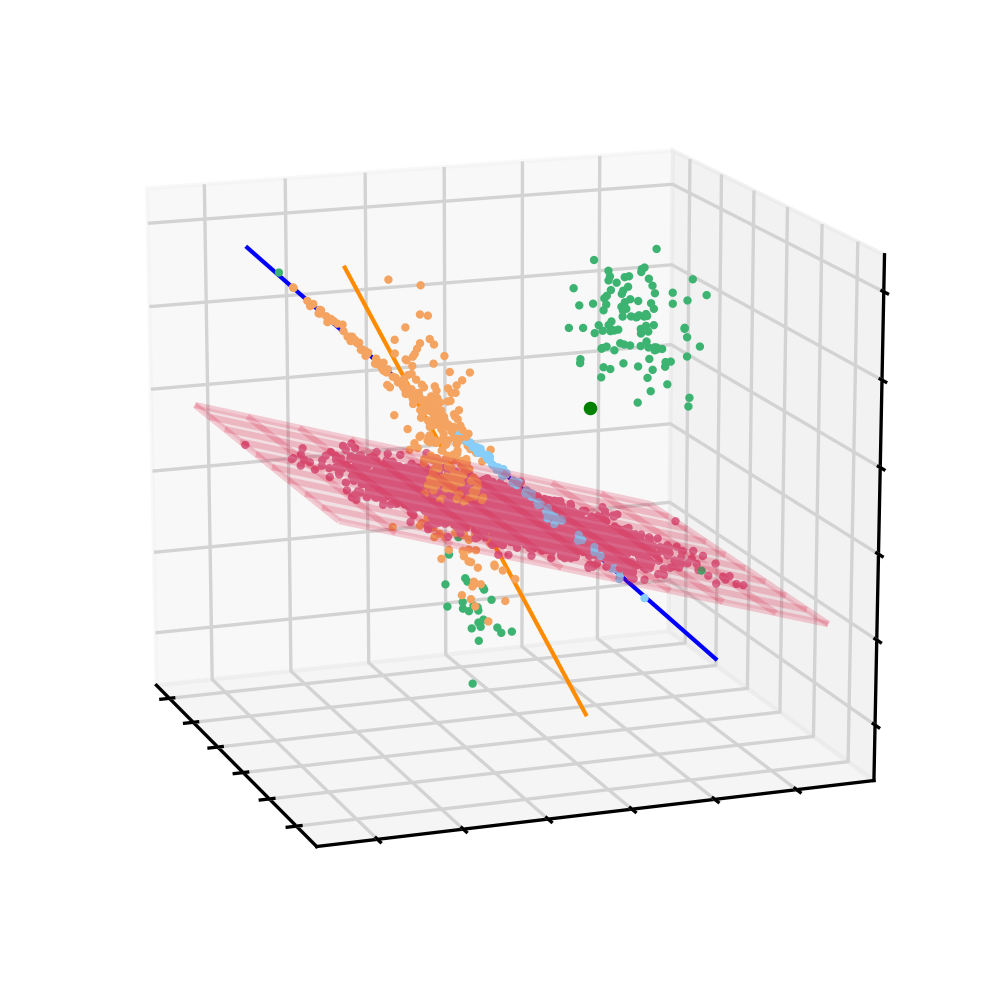

In [15]:
np.random.seed(2)
spaces, probabilities = kspaces.EM.run_EM(X, kd = [2,1,1,0], max_iter = 4, randomize_init = True)
plot_3D(X, spaces, color_probabilities = probabilities, el = 15, az = 160,)

Final:

Converged on iteration 8
Converged on iteration 13
Converged on iteration 20
Converged on iteration 19
Converged on iteration 31
Converged on iteration 50
Converged on iteration 10
Converged on iteration 16
Converged on iteration 26
Converged on iteration 24
time per EM run: 0.092
time per E, M step : [0.0012 0.0028]


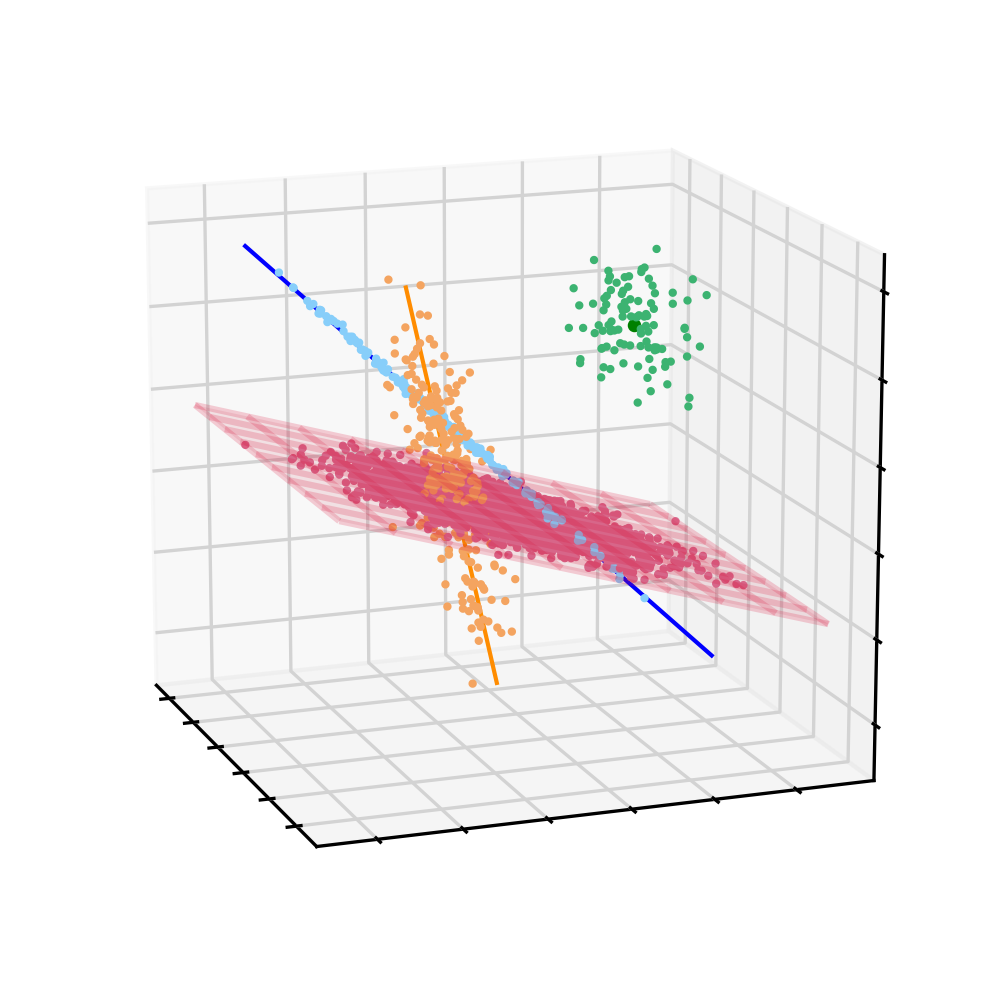

In [16]:
np.random.seed(2)
spaces, probabilities = kspaces.EM.run_EM(X, kd = [2,1,1,0], max_iter = 50, randomize_init = True)
plot_3D(X, spaces, color_probabilities = probabilities, el = 15, az = 160,)

# How to generate synthetic data from a fitted kspaces model

kspaces.generate.generate can be used to generate data from a k-spaces model. It accepts a list of affine subspaces, which can either be the result of fitting a k-spaces model or you can make your own affine_subspace objects and put them together in a list for more flexibility than kspaces.generate.generate_points_subspace.

Also, each affine subspace has its own generate() method that you can use too. It only accepts a size argument.

**Make synthetic data using the fitted model**

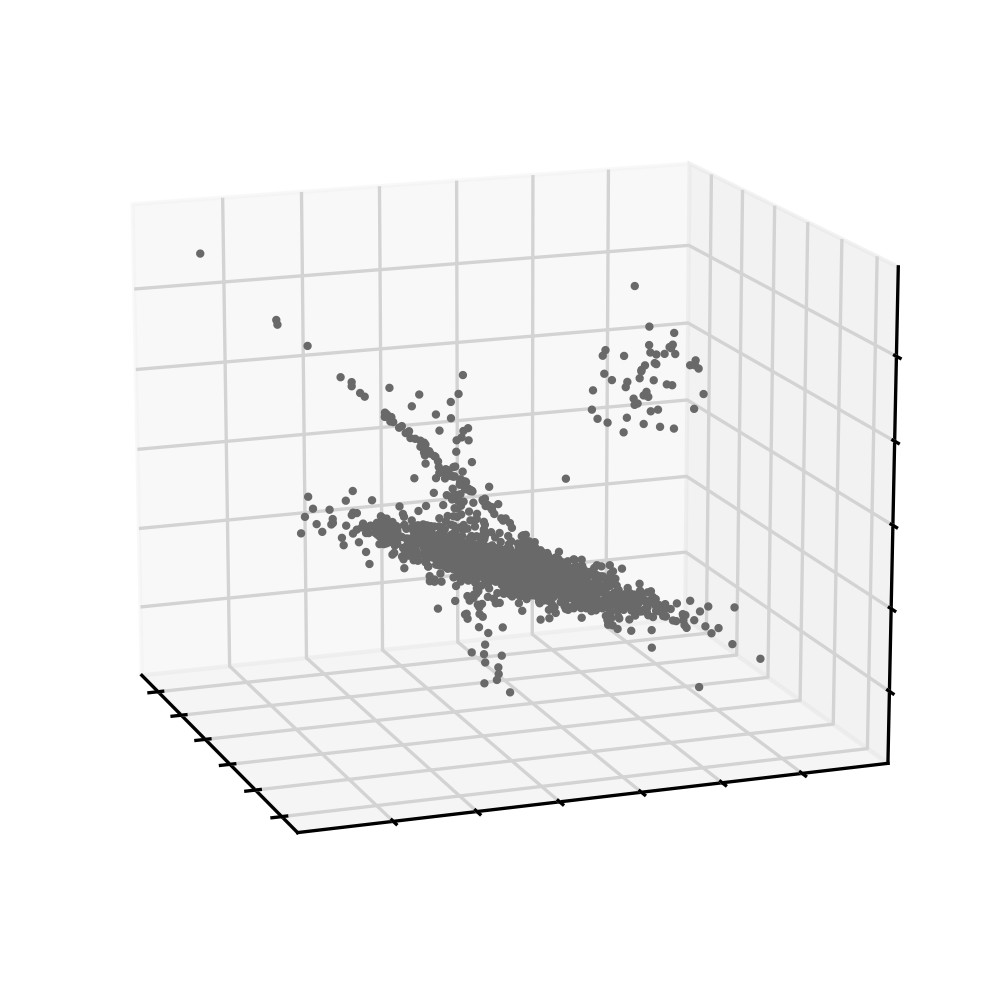

In [17]:
X_sim = kspaces.generate.generate(spaces_correct, size = 2000, seed = 0)
plot_3D(X_sim, [], color_probabilities = [], el = 15, az = 160, f = '')

# How to make affine_subspace objects directly and use those to make synthetic data

An affine subspace is **constructed** with the following arguments: vectors, translation, sigma, latent_sigmas, prior. 

'**d**' refers to the subspace dimension. Its specified indirectly through the length of the vectors list, and it is the degrees of freedom for moving around the affine subspace. 

'**D**' is the ambient dimension and is the dimension of the space the subspace 'lives' in... a line (a 1D subspace) can exist within a sheet of paper (a 2D space) or in our 3D world.

'**translation**' is what makes our subspace affine. A line passing through the origin of a graph, such as y = 2x, is a vector subspace, while a line not passing through the origin is an affine subspace, such as y = 2x + 1. Any point on that y = 2x + 1 line would work as a translation, but for a k-spaces affine_subspace object, translation also specifies the mean of the probability distribution within the subspace.

'**vectors**' is a list of lists specifying vectors that span the subspace. Its length specifies 'd'. The length of each list within vectors should be 'D'. For a 0-dimensional subspace (d=0) 'vectors' is simply this empty list '[]' and len([]) is 0. Otherwise, it should look something like this 'vectors = [[0,1,0],[1,0,0]]'. These vectors do not need to be unit vectors (length of 1) or an orthonormal basis (orthogonal to each other), because the object's constructor will handle this. If they are linearly dependednt and therefore do not span a subspace of dimension d, a random vector will be added.

'**sigma**' is the standard deviation for the isotropic Gaussian distribution in the complementary space (aka the D - d dimensional space that is outside of the subspace)

'**latent_sigmas**' is a list of length 'd' that gives the standard deviations for the multivariate Gaussian within the subspace

'**prior**' is the mixture component weight for this subspace. It is the prior probability that a point belongs to this subspace before seeing its coordinates.

===============================================================================================================================================================

An affine_subspace instance has the following **data attributes** (plus many methods):

'**d**' int. subspace dimension

'**D**' int. ambient space dimension

'**translation**' numpy array. mean of the distribution

'**vectors**' 2-D numpy array. orthonormal basis vectors

'**sigma**' float. sigma > 0

'**latent_sigmas**' numpy array. latent_sigmas > 0

'**prior**' float. 0 < prior <= 1

In [18]:
#the length of this vector determines the dimension of the affine_subspace's ambient space, here D = 3
translation = [0,-4,0] 

#the noise for points
sigma = 0.2 

#the displacement within the subspace for points
latent_sigmas = [1] 

#make a 1-dimensional subspace (aka a line)
#this will be rescaled to a unit vector by the constructor
vector = [1,-2,3] 
vectors = [vector] #the constructor  expects a list of vectors, even for a subspace with d = 1

#the mixture weight for this component of the model
prior = 0.7

#make the affine_subspace
s1 = kspaces.affine_subspace_.affine_subspace(vectors,translation,sigma, latent_sigmas, prior)

In [19]:
# make a 0-dimensional subpace
translation = [10,0,0]
sigma = 0.1
latent_sigmas = [] #empty list
vectors = [] #empty list
prior = 0.2
s2 = kspaces.affine_subspace_.affine_subspace(vectors,translation,sigma, latent_sigmas, prior)

In [20]:
# make a 2-dimensional subpace
translation = [0,0,0]
sigma = 0.1
latent_sigmas = [1.1,2.5]
vectors = [[1,1,1],
          [1,-1,1]] #empty list
prior = 0.1
s3 = kspaces.affine_subspace_.affine_subspace(vectors,translation,sigma, latent_sigmas, prior)

**Make some synthetic data and plot it**

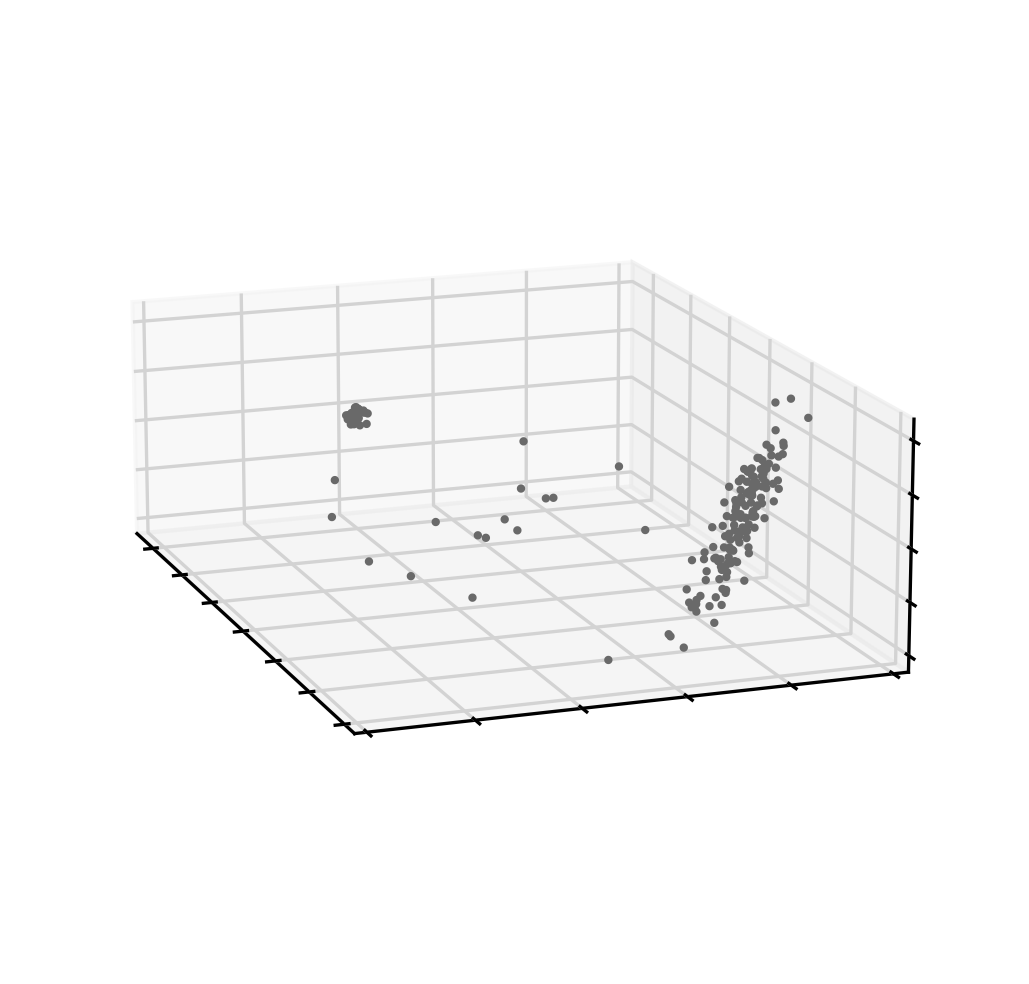

In [21]:
X_sim_2 = kspaces.generate.generate([s1,s2,s3], size = 200, seed = 0)
plot_3D(X_sim_2, [], el = 15, az = 160, f = '')

# How to assign points or compute their ownership using kspaces.EM.E_step

We fit the model to X, but we have this new data from X_sim. We can compute the probability that each space generated each point with another expectation step.

In [22]:
probs = kspaces.EM.E_step(X_sim, spaces_correct, assignment = 'soft') 
np.round(probs[:30], 2)

array([[1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.98, 0.  , 0.02, 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.98, 0.  , 0.02, 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.32, 0.68, 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

Or we can use hard assignment

In [23]:
probs = kspaces.EM.E_step(X_sim, spaces_correct, assignment = 'hard') 
probs[:30]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

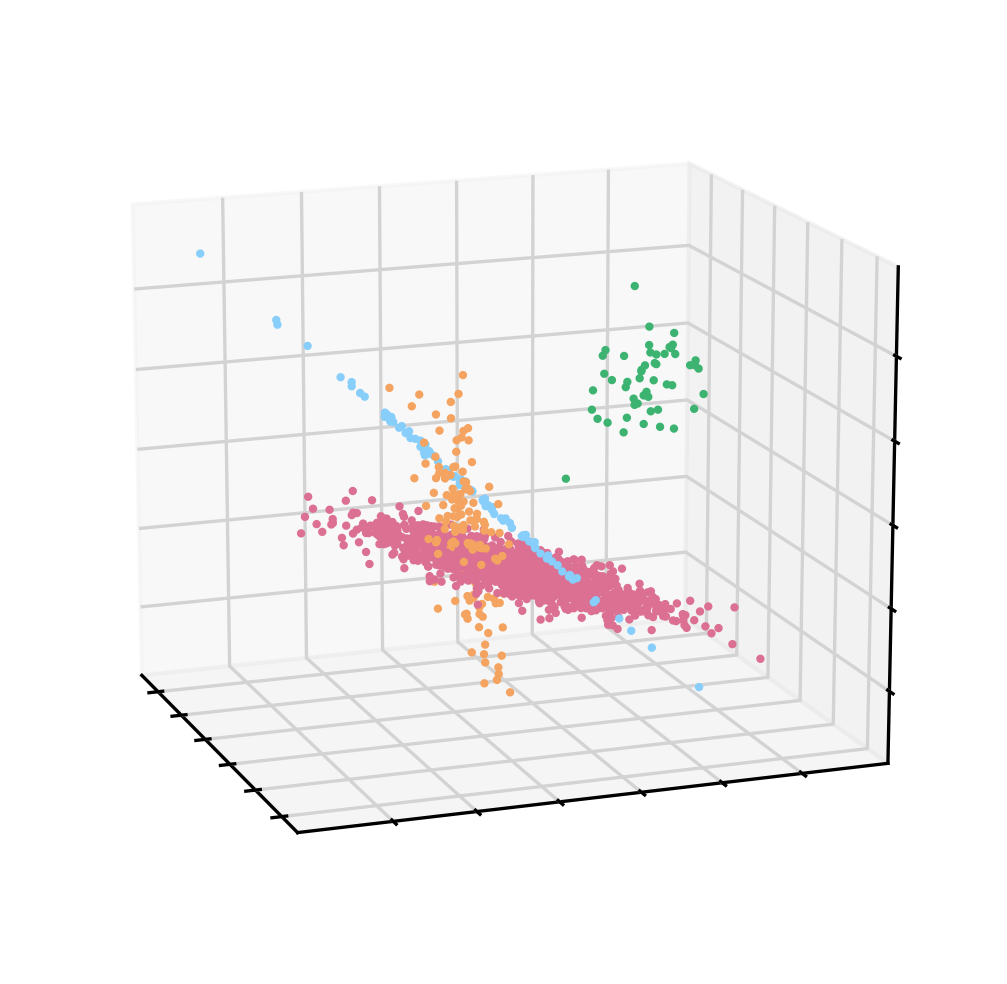

In [24]:
plot_3D(X_sim, [], color_probabilities = probs, el = 15, az = 160, f = '')

# Other EM initializations that didn't work on the toy example:

Not every EM run converges on the globally optimal solution, which, by the way, may not be identical to the "ground truth" parameters used to generate the data. The globally optimal solution is the solution with the highest likelihood for the observed data with the specified model hyperparameters. That's it.

**Here are examples of locally optimal solutions that are not globally optimal, which is why we initialize EM many times in practice.**

Converged on iteration 29
time per EM run: 0.12
time per E, M step : [0.0011 0.0028]


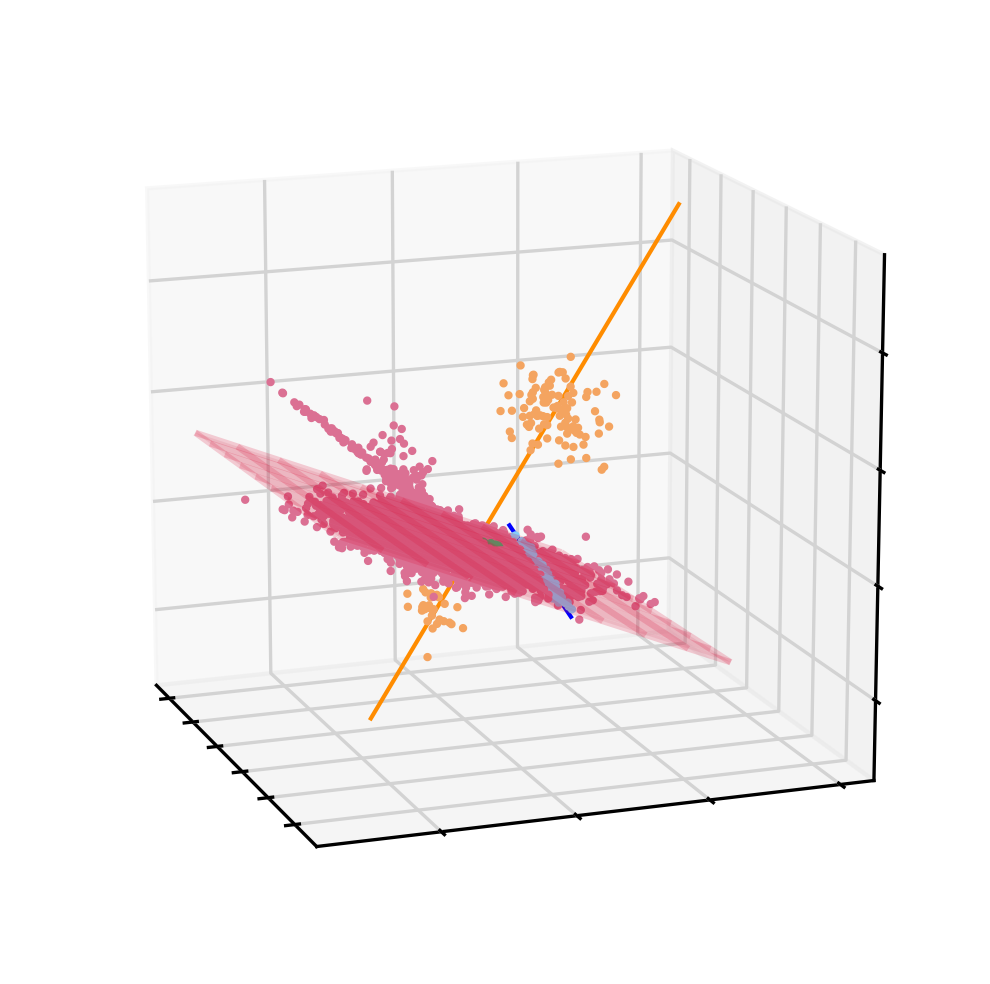

In [25]:
np.random.seed(0)
spaces0, probabilities0 = kspaces.EM.run_EM(X, kd = [2,1,1,0], max_iter = 50, initializations = 1, randomize_init = True)
plot_3D(X, spaces0, color_probabilities = probabilities0, el = 15, az = 160 , sd_length = 3)

Converged on iteration 12
time per EM run: 0.053
time per E, M step : [0.0012 0.003 ]


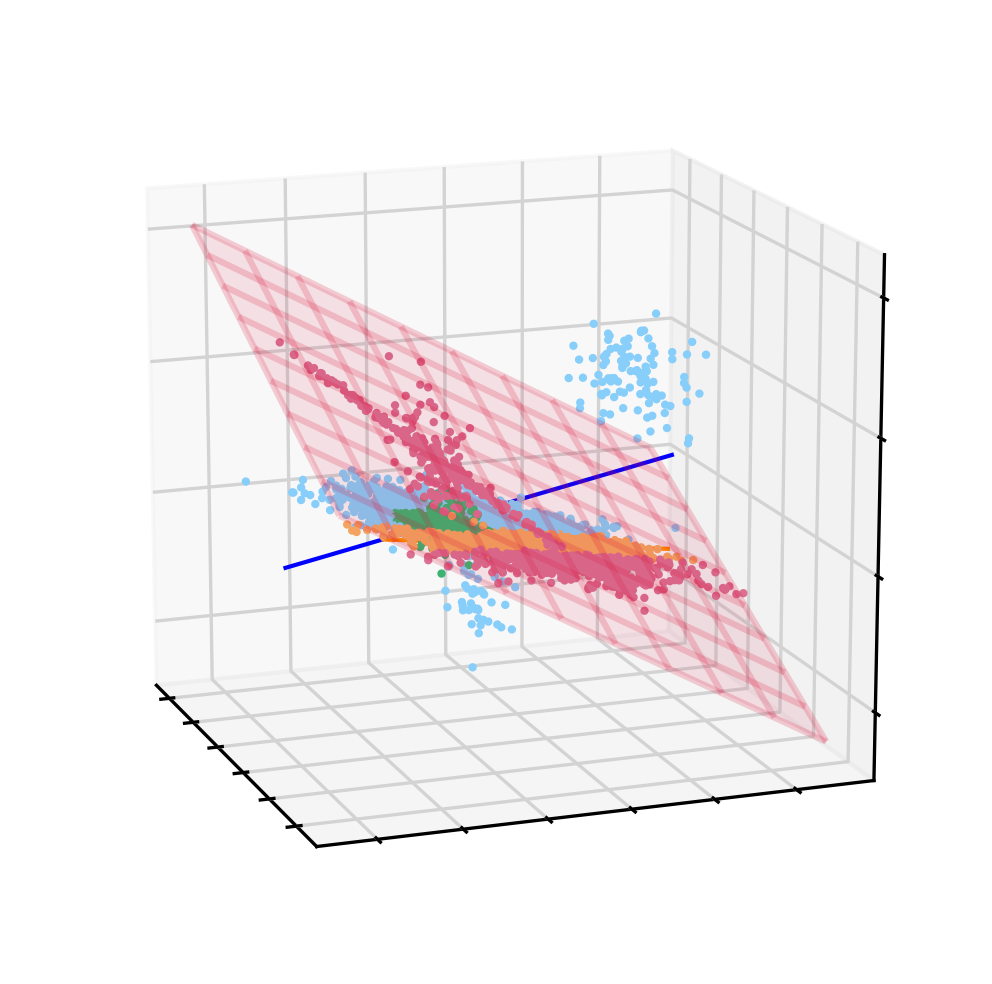

In [26]:
np.random.seed(1)
spaces1, probabilities1 = kspaces.EM.run_EM(X, kd = [2,1,1,0], max_iter = 50, initializations = 1, randomize_init = True)
plot_3D(X, spaces1, color_probabilities = probabilities1, el = 15, az = 160, sd_length = 3)

# Misspecify kd to get some other examples for model selection

Converged on iteration 10
time per EM run: 0.049
time per E, M step : [0.0015 0.003 ]


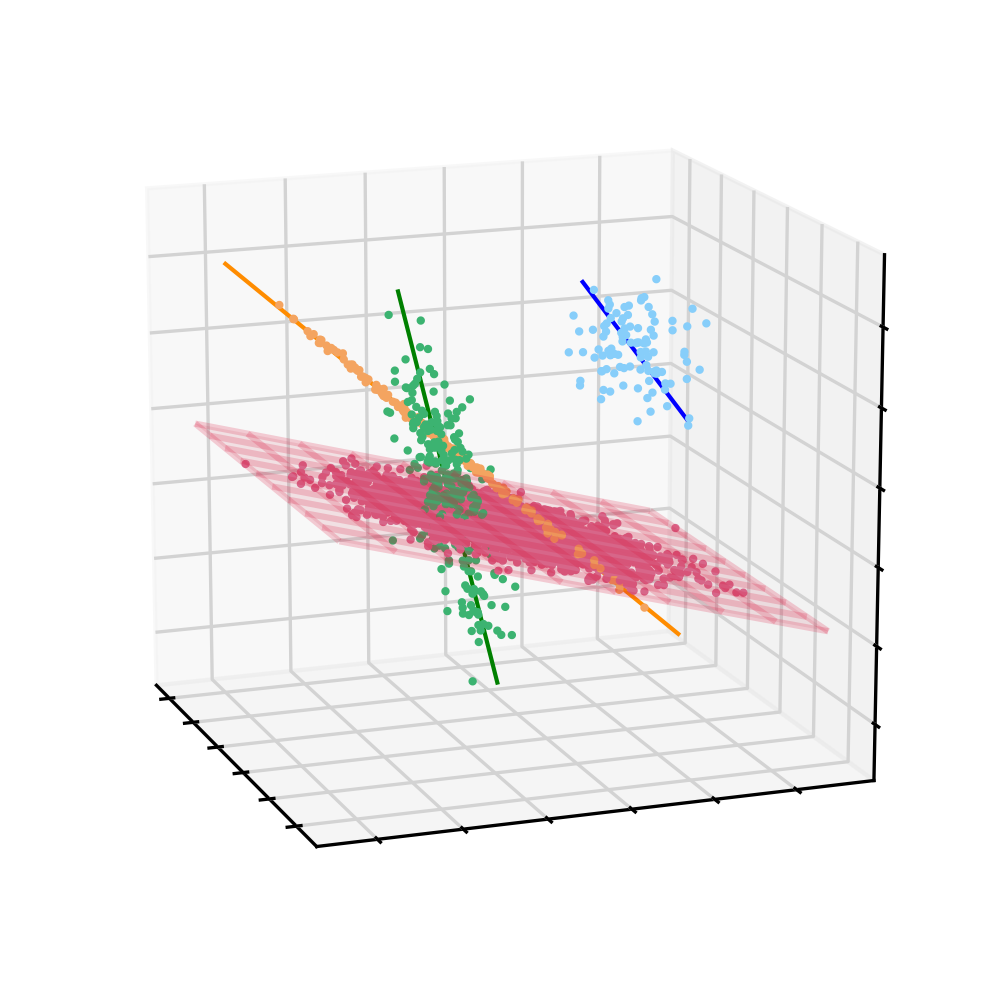

In [27]:
np.random.seed(1)
spaces_extra, probabilities = kspaces.EM.run_EM(X, kd = [2,1,1,1], max_iter = 50, initializations = 1, randomize_init = True)
plot_3D(X, spaces_extra, color_probabilities = probabilities, el = 15, az = 160, sd_length = 3)

Converged on iteration 31
time per EM run: 0.138
time per E, M step : [0.0015 0.0028]


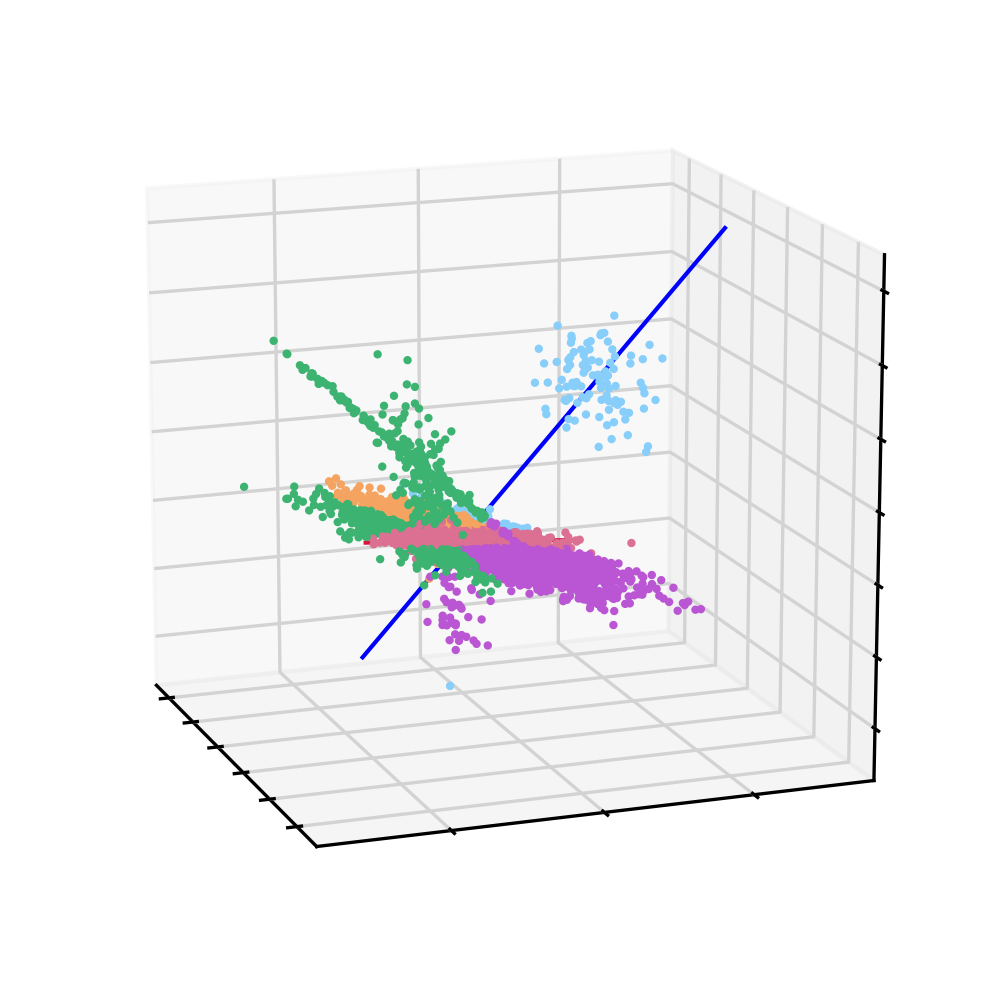

In [28]:
np.random.seed(1)
spaces_under, probabilities = kspaces.EM.run_EM(X, kd = [1,1,0,0,0], max_iter = 50, initializations = 1, randomize_init = True)
plot_3D(X, spaces_under, color_probabilities = probabilities, el = 15, az = 160, sd_length = 3)

In [29]:
alternates = [spaces0, spaces1, spaces_extra, spaces_under]
for a in alternates:
    print('seed 2 vs alternate solution:')
    kspaces.model_selection.model_selection(X, spaces_correct, a)
    print('vice versa - alternate solution vs seed 2')
    kspaces.model_selection.model_selection(X, a, spaces_correct)
    print()

seed 2 vs alternate solution:
Same degrees of freedom: model has higher likelihood
vice versa - alternate solution vs seed 2
Same degrees of freedom: model does not have higher likelihood than null

seed 2 vs alternate solution:
Same degrees of freedom: model has higher likelihood
vice versa - alternate solution vs seed 2
Same degrees of freedom: model does not have higher likelihood than null

seed 2 vs alternate solution:
BIC model is lower
47696.43092315864 < 47716.69942305494
vice versa - alternate solution vs seed 2
BIC model is not lower

seed 2 vs alternate solution:
BIC model is lower
47696.43092315864 < 69721.3737461844
vice versa - alternate solution vs seed 2
BIC model is not lower



(The printed message is different for the top two because when the model specification is the same (kd is the same for both), we can just compare the likelihood).

In [30]:
alternates = [spaces0, spaces1, spaces_extra, spaces_under]
for a in alternates:
    print('seed 2 vs alternate solution:')
    kspaces.model_selection.model_selection(X, spaces_correct, a, test = 'ICL')
    print('vice versa - alternate solution vs seed 2')
    kspaces.model_selection.model_selection(X, a, spaces_correct, test = 'ICL')
    print()

seed 2 vs alternate solution:
ICL model is lower
47765.78313719538 < 68563.97231060614
vice versa - alternate solution vs seed 2
ICL model is not lower

seed 2 vs alternate solution:
ICL model is lower
47765.78313719538 < 71190.58229294165
vice versa - alternate solution vs seed 2
ICL model is not lower

seed 2 vs alternate solution:
ICL model is lower
47765.78313719538 < 47786.05163578309
vice versa - alternate solution vs seed 2
ICL model is not lower

seed 2 vs alternate solution:
ICL model is lower
47765.78313719538 < 71057.35567002215
vice versa - alternate solution vs seed 2
ICL model is not lower



# More model selection examples on another toy dataset

## example 1

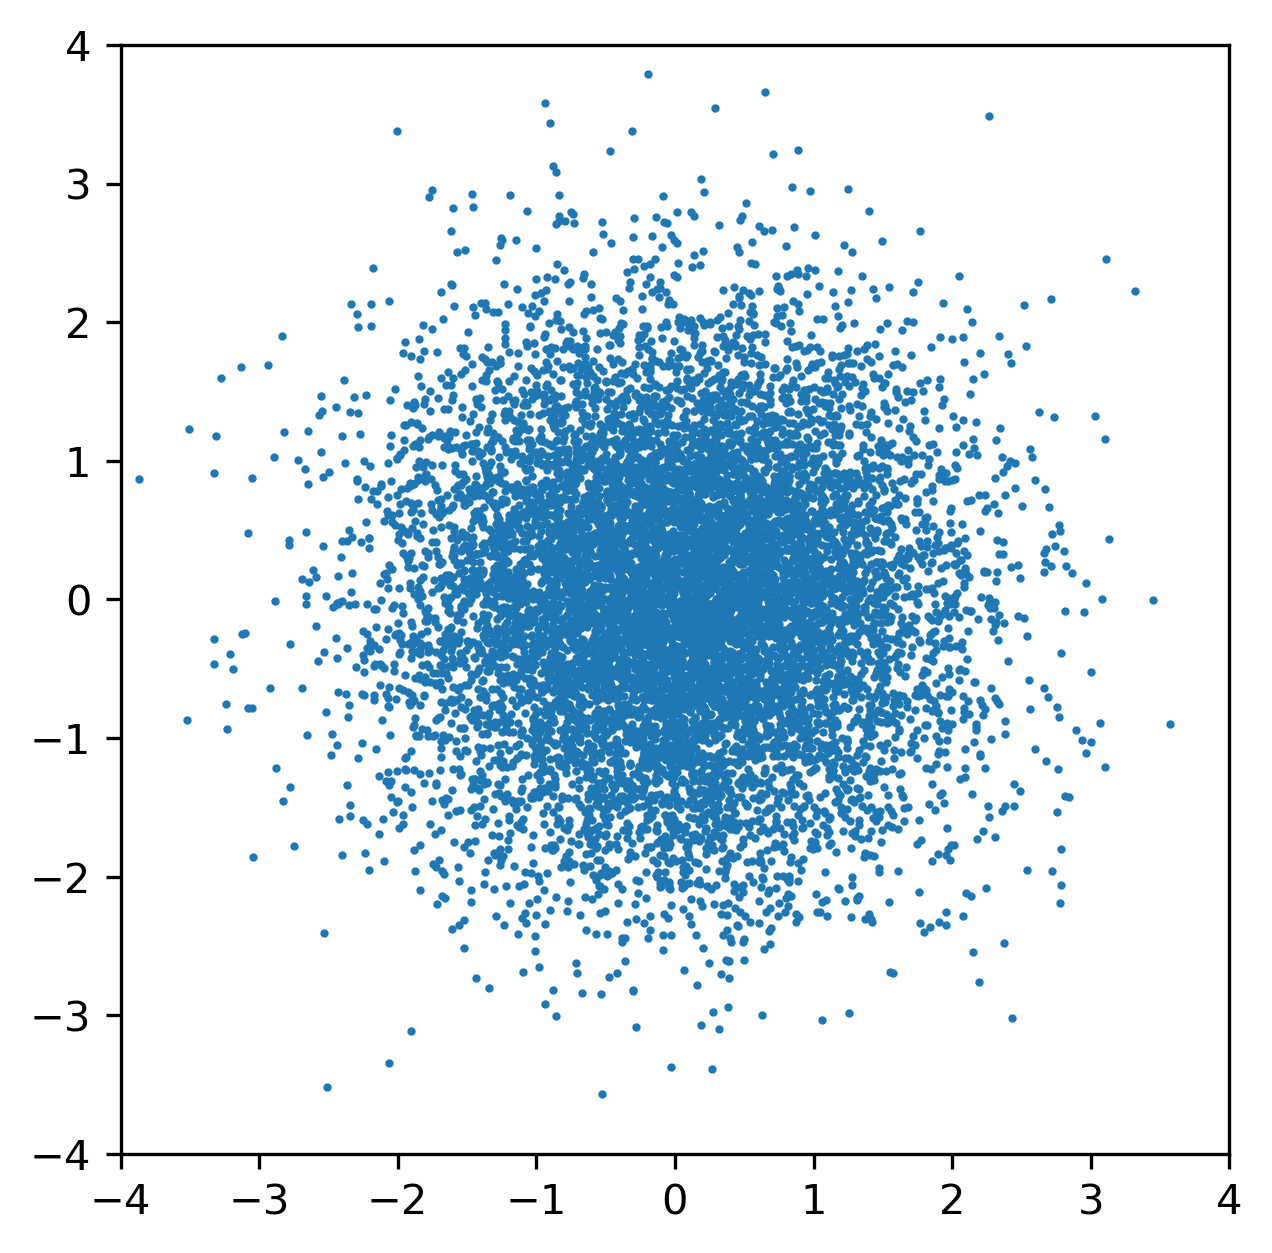

In [31]:
ground_truth = [kspaces.affine_subspace_.affine_subspace([],[0,0],1,[],1)]
points= kspaces.generate.generate(ground_truth, size = 10000)
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1)
ax.set_xlim((-4,4))
ax.set_ylim((-4,4))
ax.set_aspect('equal')

In [32]:
s0 = kspaces.EM.fit_single_space(points,0)
p0 = np.array([[1]]*10000)

In [33]:
s1 = kspaces.EM.fit_single_space(points,1)
p1 = np.array([[1]]*10000)

**Reject a line vs a point**

In [34]:
kspaces.model_selection.model_selection(points, [s1], [s0])

BIC model is not lower


'null'

**Reject two points vs one**

In [35]:
s0 = kspaces.EM.fit_single_space(points,0)
p0 = np.array([[1]]*10000)

In [36]:
s1, p1 = kspaces.EM.run_EM(points,[0,0],assignment = 'soft', max_iter = 3)

max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
time per EM run: 0.007
time per E, M step : [0.0006 0.0014]


In [37]:
np.sum(np.argmax(p1, axis = 1) ==1) # if this is 0 or 10000, then all the points are hard-assigned to one space

0

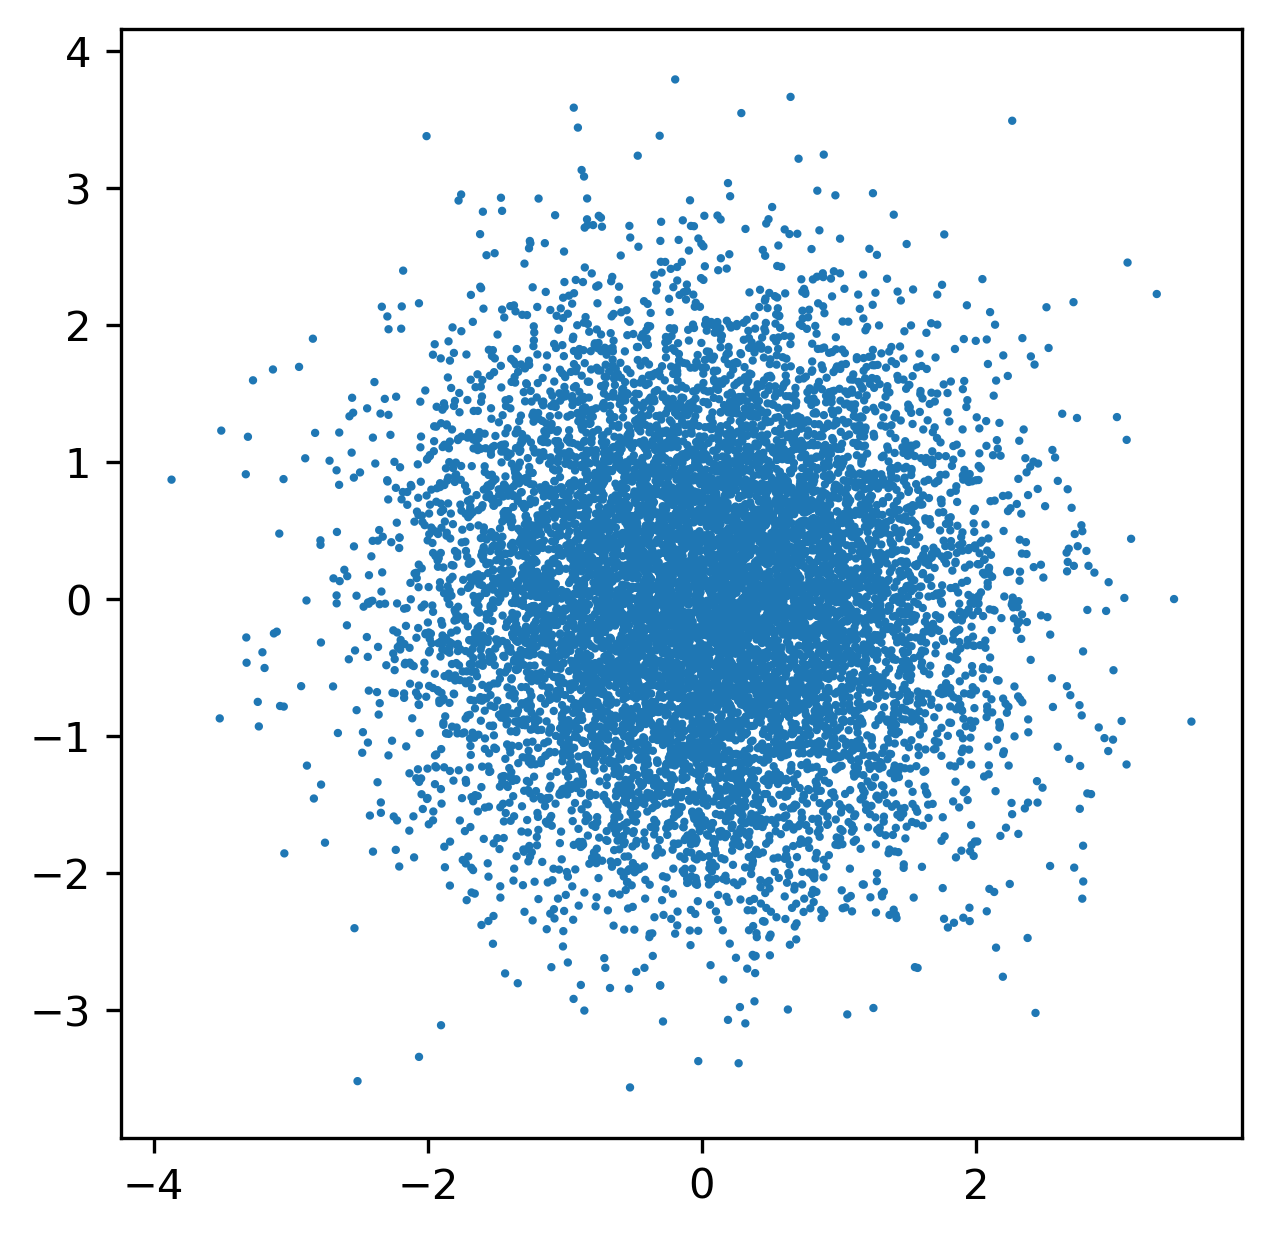

In [38]:
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1, c = np.argmax(p1, axis = 1), cmap = 'tab10')
ax.set_aspect('equal')

In [39]:
kspaces.model_selection.model_selection(points, s1, [s0])

BIC model is not lower


'null'

## example 2

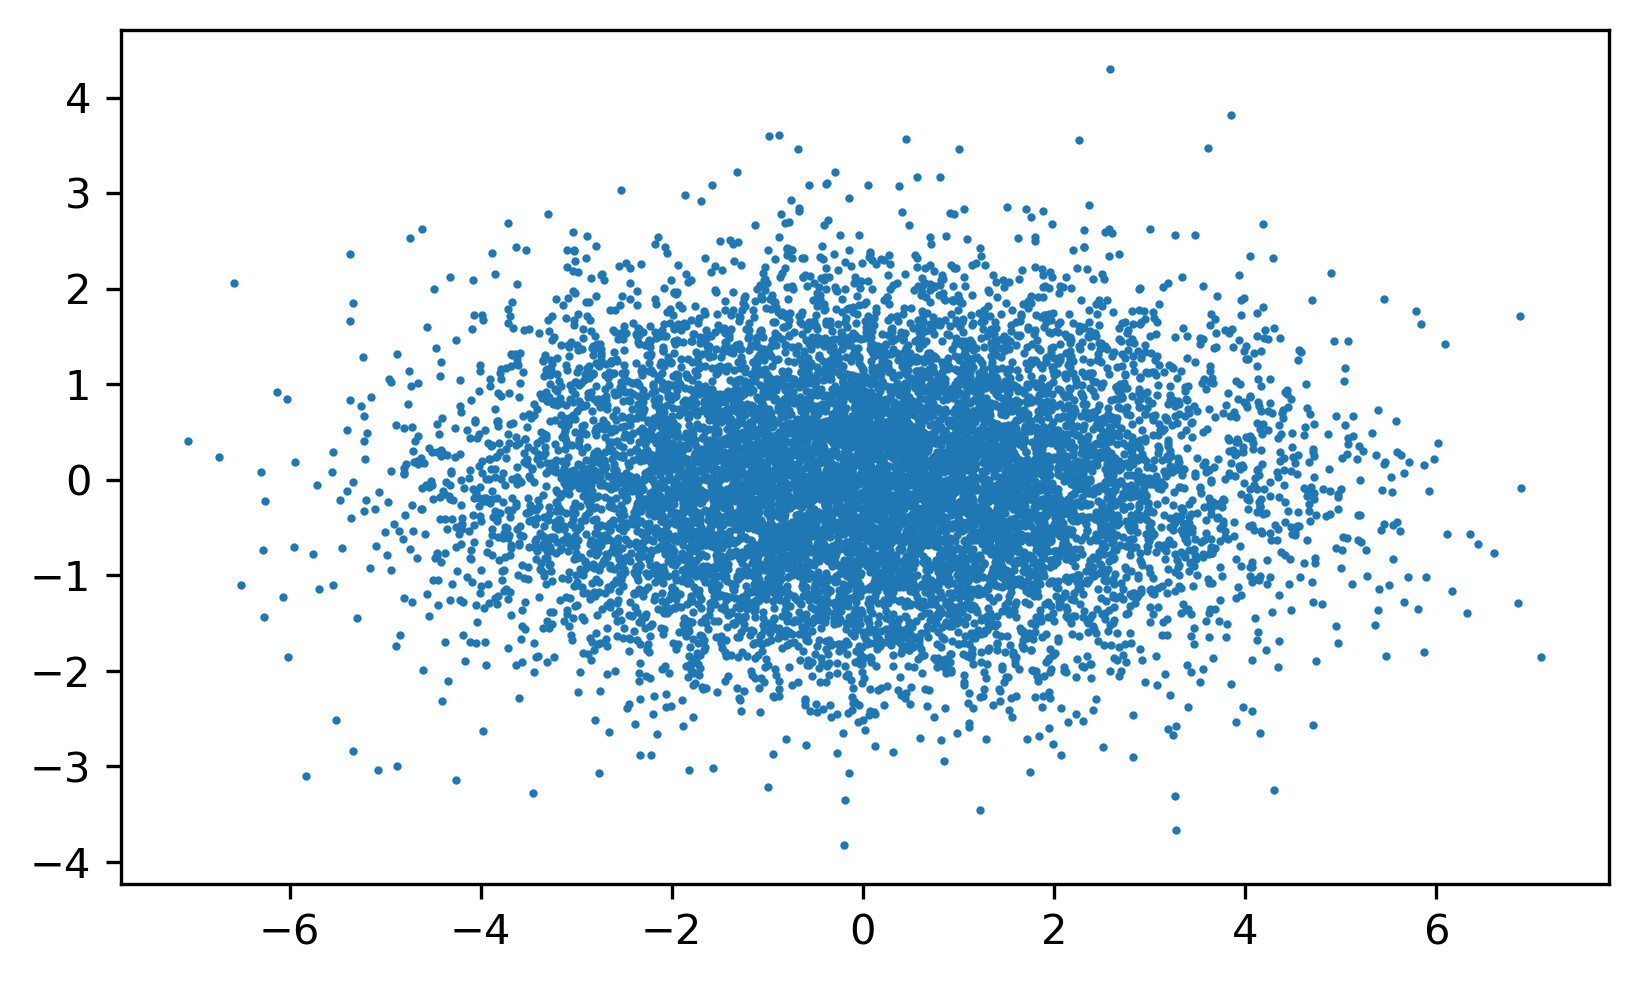

In [40]:
ground_truth = [kspaces.affine_subspace_.affine_subspace([[1,0]],[0,0],1,[2],1)]
points = kspaces.generate.generate(ground_truth, size = 10000)
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1)

ax.set_aspect('equal')

In [41]:
s0 = kspaces.EM.fit_single_space(points,0)
p0 = np.array([[1]]*10000)

In [42]:
s1 = kspaces.EM.fit_single_space(points,1)
p1 = np.array([[1]]*10000)

**Dont reject a line vs a point**

In [43]:
kspaces.model_selection.model_selection(points, [s1], [s0])

BIC model is lower
70437.50749397166 < 74801.99713863683


'model'

**Reject two lines vs one**

In [44]:
s0 = kspaces.EM.fit_single_space(points,1)
p0 = np.array([[1]]*10000)

In [45]:
s1, p1 = kspaces.EM.run_EM(points,[1,1],assignment = 'soft', max_iter = 3)

max iteration 3 completed
Converged on iteration 2
max iteration 3 completed
Converged on iteration 3
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
Converged on iteration 2
time per EM run: 0.017
time per E, M step : [0.0014 0.0017]


In [46]:
np.sum(np.argmax(p1, axis = 1) ==1) # if this is 0 or 10000, then all the points are hard-assigned to one space

10000

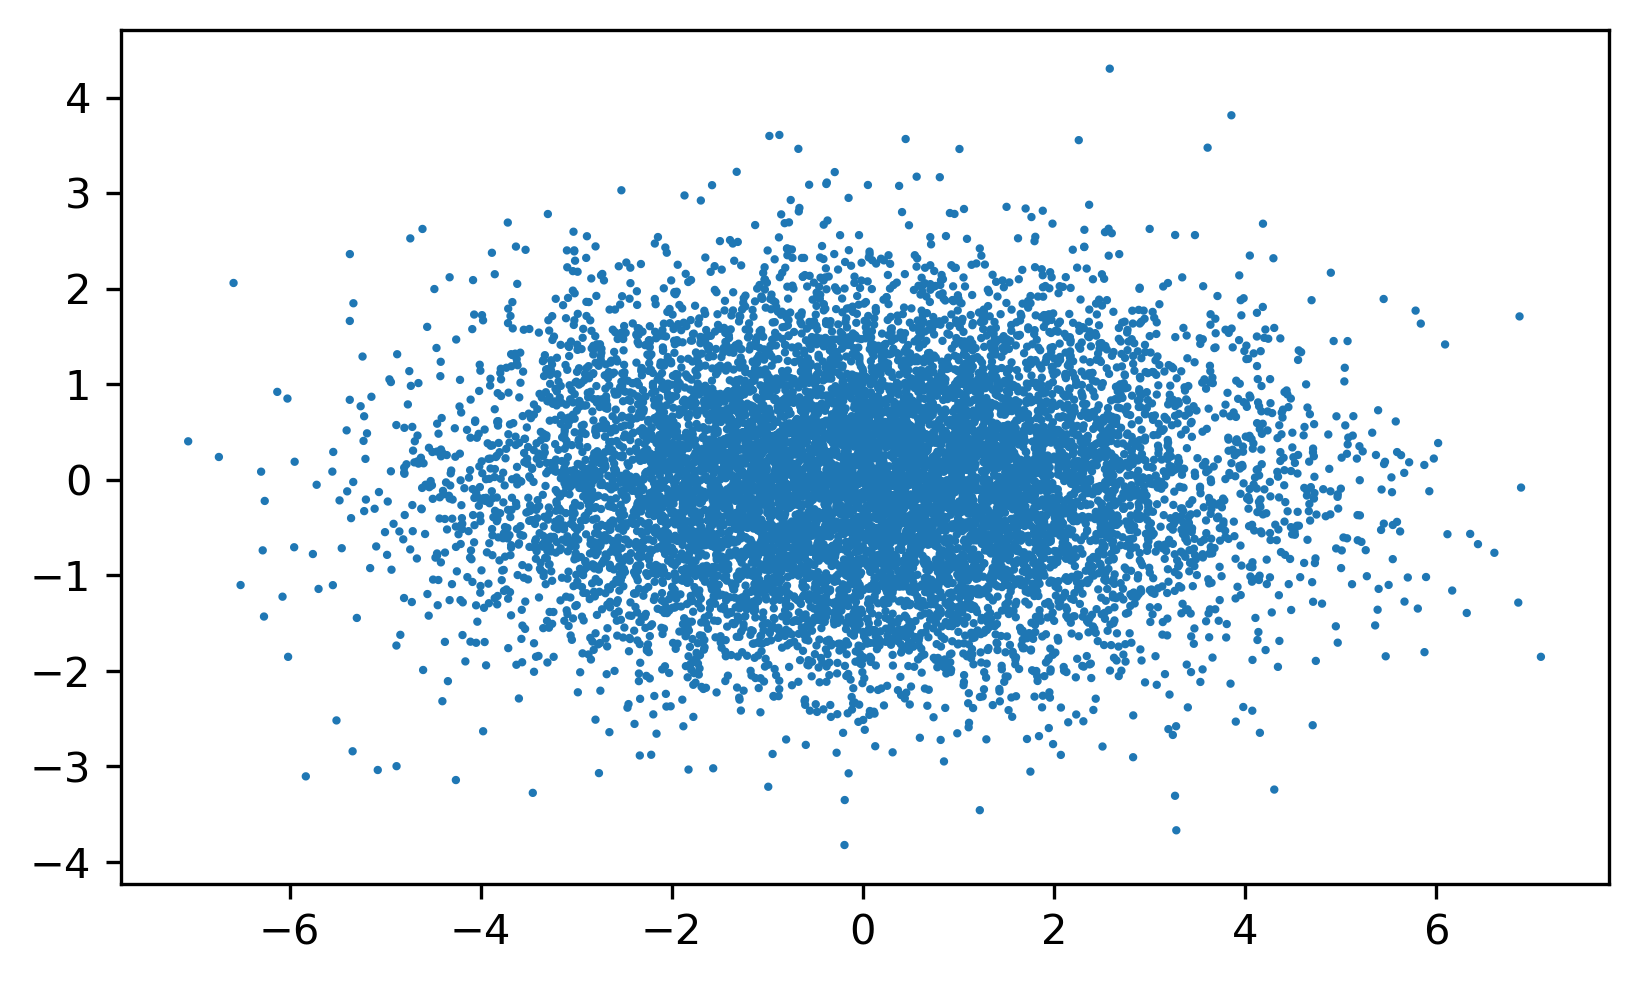

In [47]:
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1, c = np.argmax(p1, axis = 1), cmap = 'tab10')
ax.set_aspect('equal')

In [48]:
kspaces.model_selection.model_selection(points, s1, [s0])

BIC model is not lower


'null'

## example 3

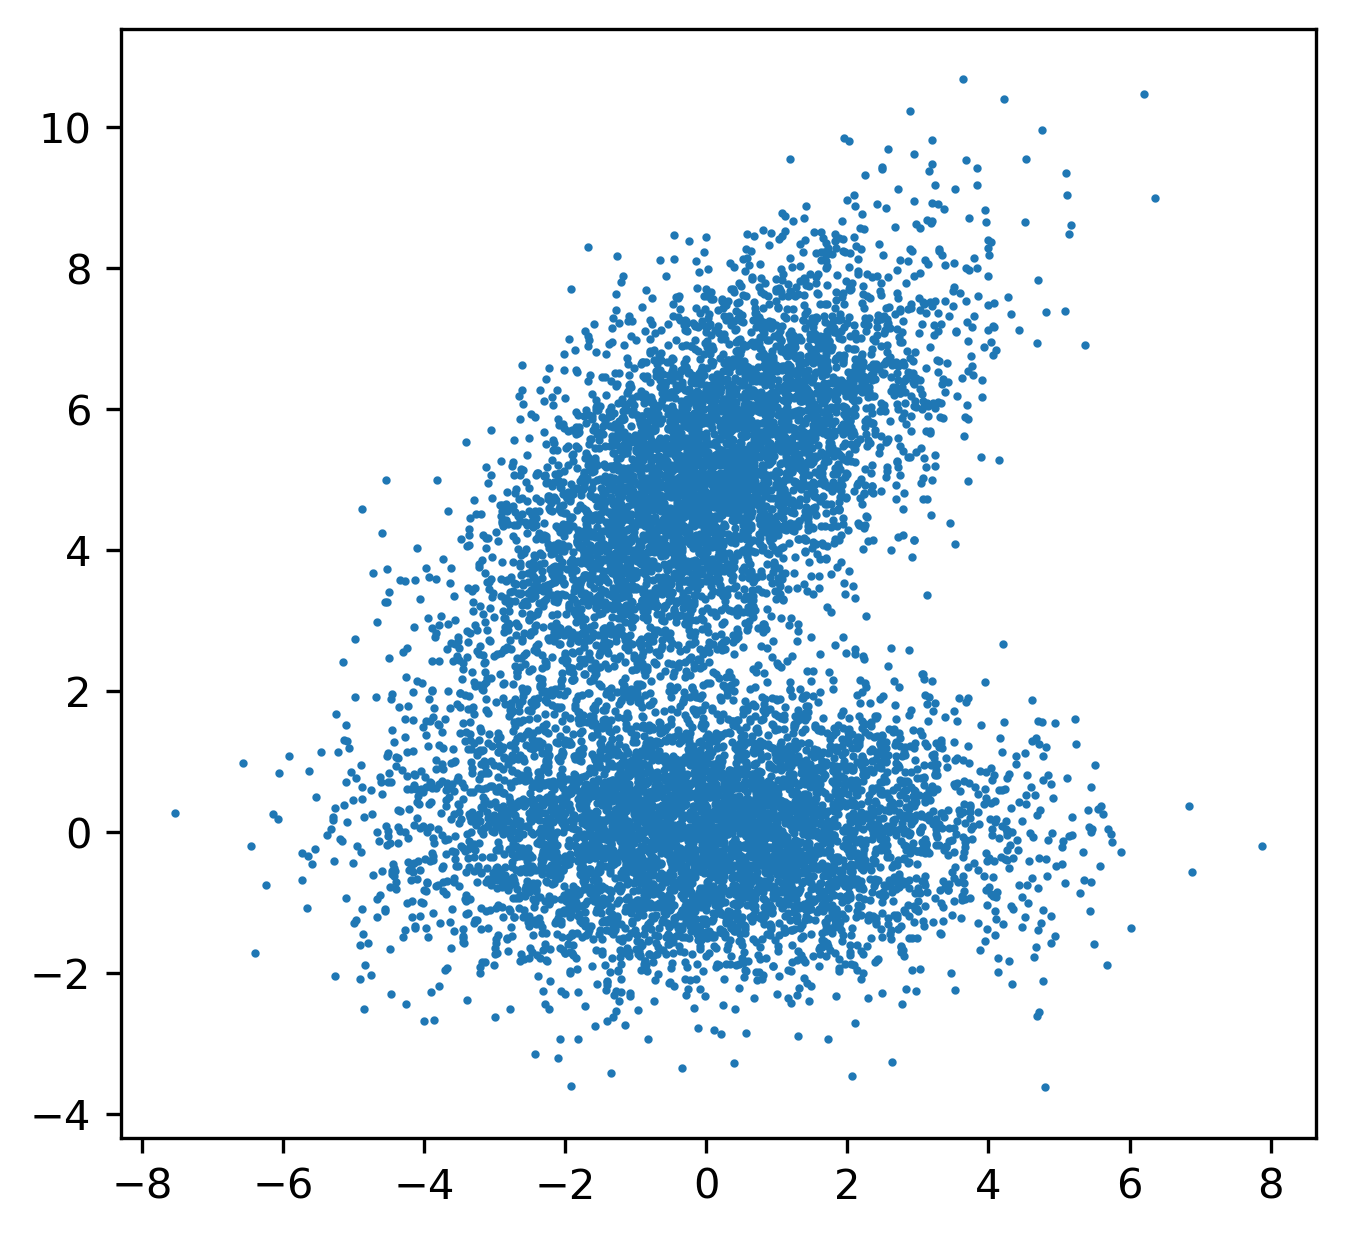

In [49]:
ground_truth = [kspaces.affine_subspace_.affine_subspace([[1,0]],[0,0],1,[2],1), kspaces.affine_subspace_.affine_subspace([[1,1]],[0,5],1,[2],1) ]
points= kspaces.generate.generate(ground_truth, size = 10000)
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1)

ax.set_aspect('equal')

**Dont reject two lines vs one**

In [50]:
s0 = kspaces.EM.fit_single_space(points,1)
p0 = np.array([[1]]*10000)

In [51]:
s1, p1 = kspaces.EM.run_EM(points,[1,1],assignment = 'soft', tol = 1e-5, max_iter = 200, initializations = 10)

Converged on iteration 35
Converged on iteration 26
Converged on iteration 34
Converged on iteration 58
Converged on iteration 48
Converged on iteration 51
Converged on iteration 43
Converged on iteration 38
Converged on iteration 48
Converged on iteration 36
time per EM run: 0.132
time per E, M step : [0.0013 0.0017]


In [52]:
np.sum(np.argmax(p1, axis = 1) ==1) # if this is 0 or 10000, then all the points are hard-assigned to one space

4884

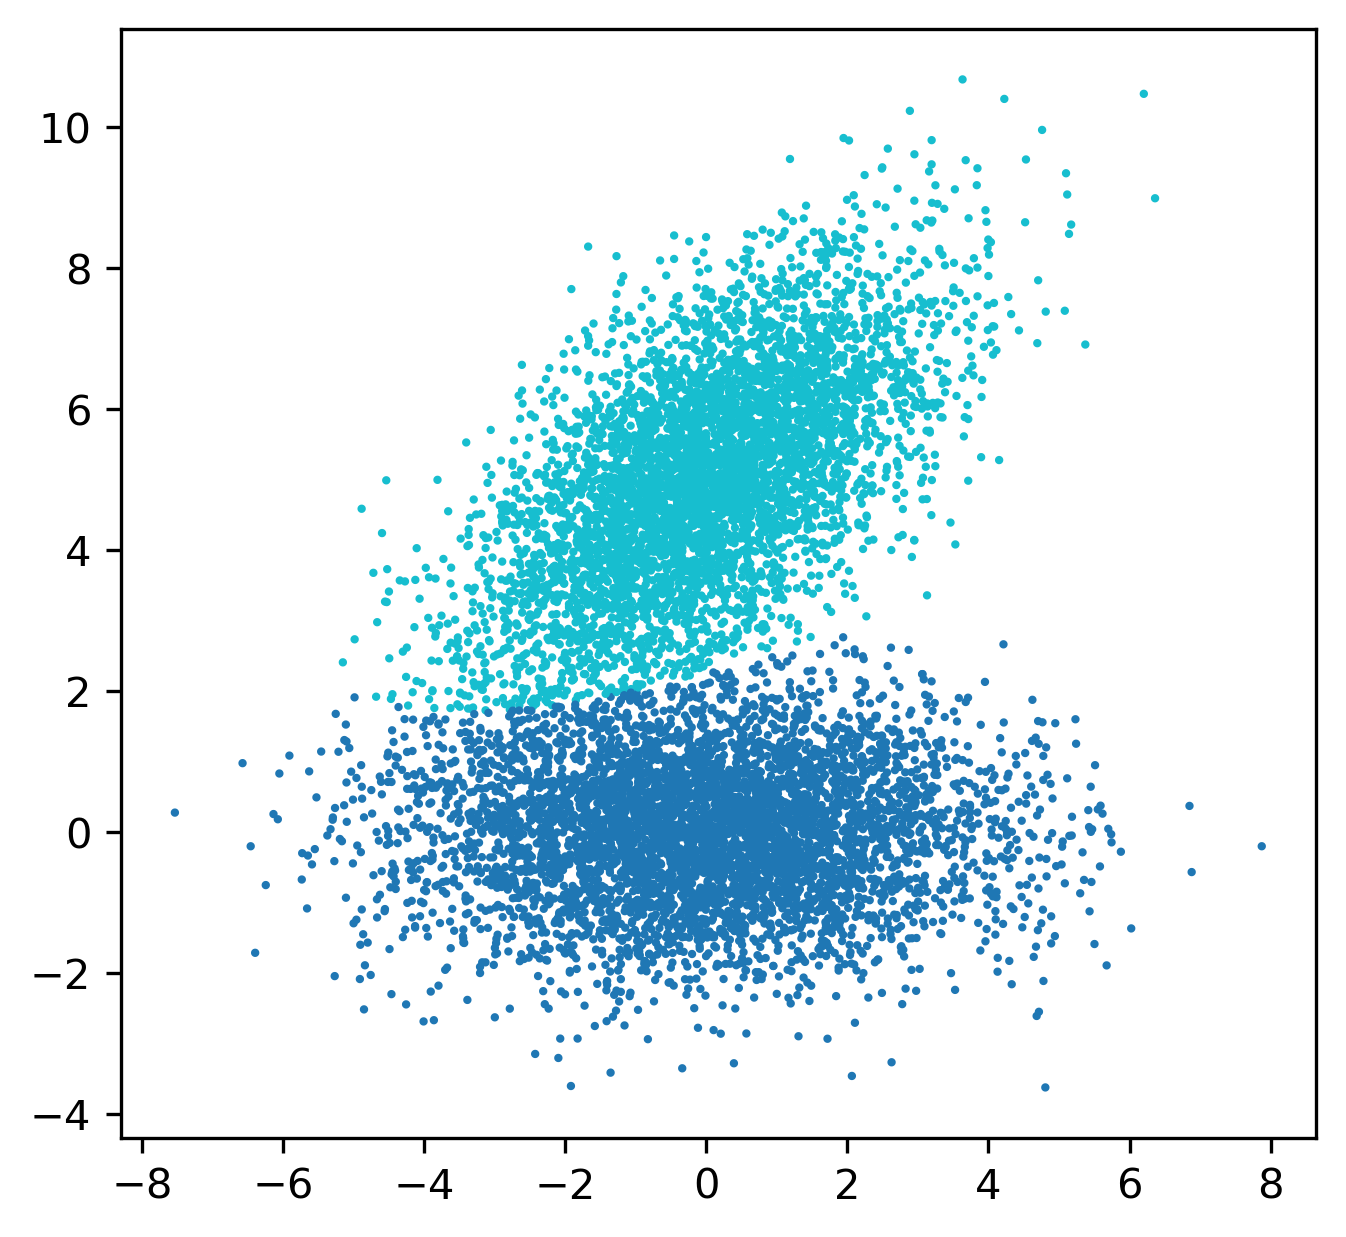

In [53]:
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1, c = np.argmax(p1, axis = 1), cmap = 'tab10')
ax.set_aspect('equal')

In [54]:
kspaces.model_selection.model_selection(points, s1, [s0])

BIC model is lower
83625.45122007783 < 89444.08294513213


'model'

## example 4

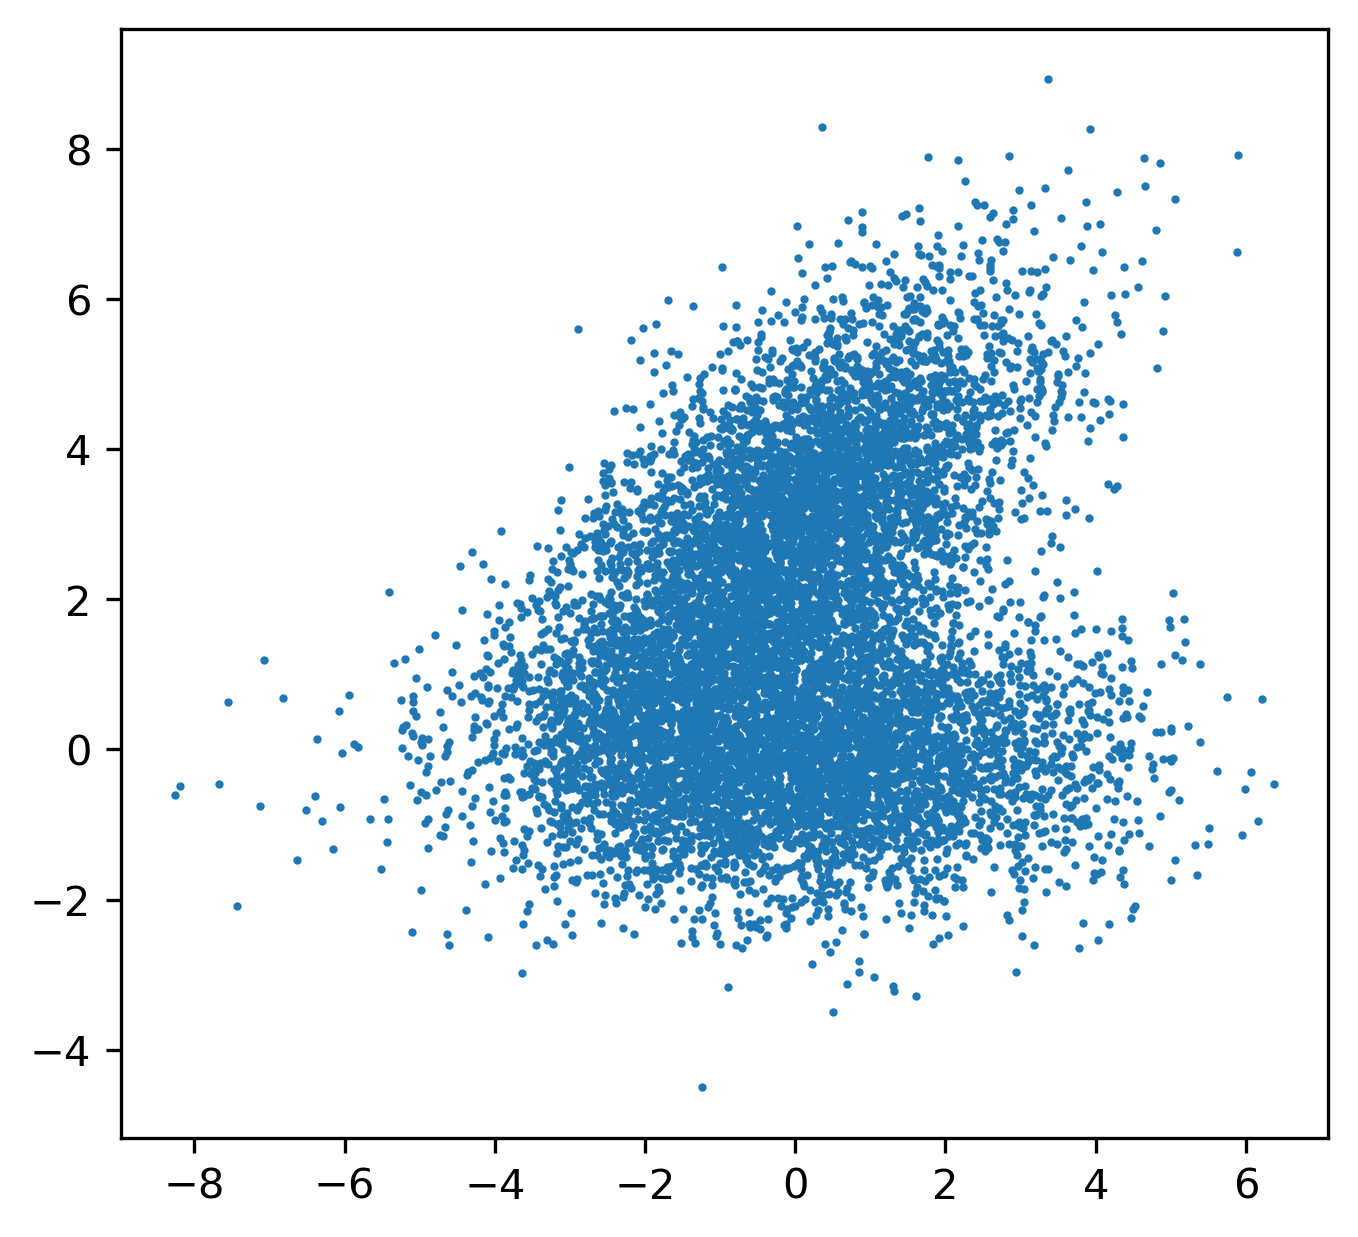

In [55]:
ground_truth = [kspaces.affine_subspace_.affine_subspace([[1,0]],[0,0],1,[2],1), kspaces.affine_subspace_.affine_subspace([[1,1]],[0,3],1,[2],1) ]
points = kspaces.generate.generate(ground_truth, size = 10000)
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1)

ax.set_aspect('equal')

**Dont reject two lines vs one**

In [56]:
s0 = kspaces.EM.fit_single_space(points,1)
p0 = np.array([[1]]*10000)

In [57]:
s1, p1 = kspaces.EM.run_EM(points,[1,1],assignment = 'soft', tol = 1e-5, max_iter = 200, initializations = 5)

Converged on iteration 104
Converged on iteration 114
Converged on iteration 122
Converged on iteration 110
Converged on iteration 140
time per EM run: 0.367
time per E, M step : [0.0013 0.0017]


In [58]:
np.sum(np.argmax(p1, axis = 1) ==1) # if this is 0 or 10000, then all the points are hard-assigned to one space

5204

In [59]:
def get_line(s,n_devs = 2):
    latent_sigma = s.latent_sigmas[0]
    return np.vstack([s.translation - n_devs*latent_sigma*s.vectors[0],s.translation + n_devs*latent_sigma*s.vectors[0]]).T

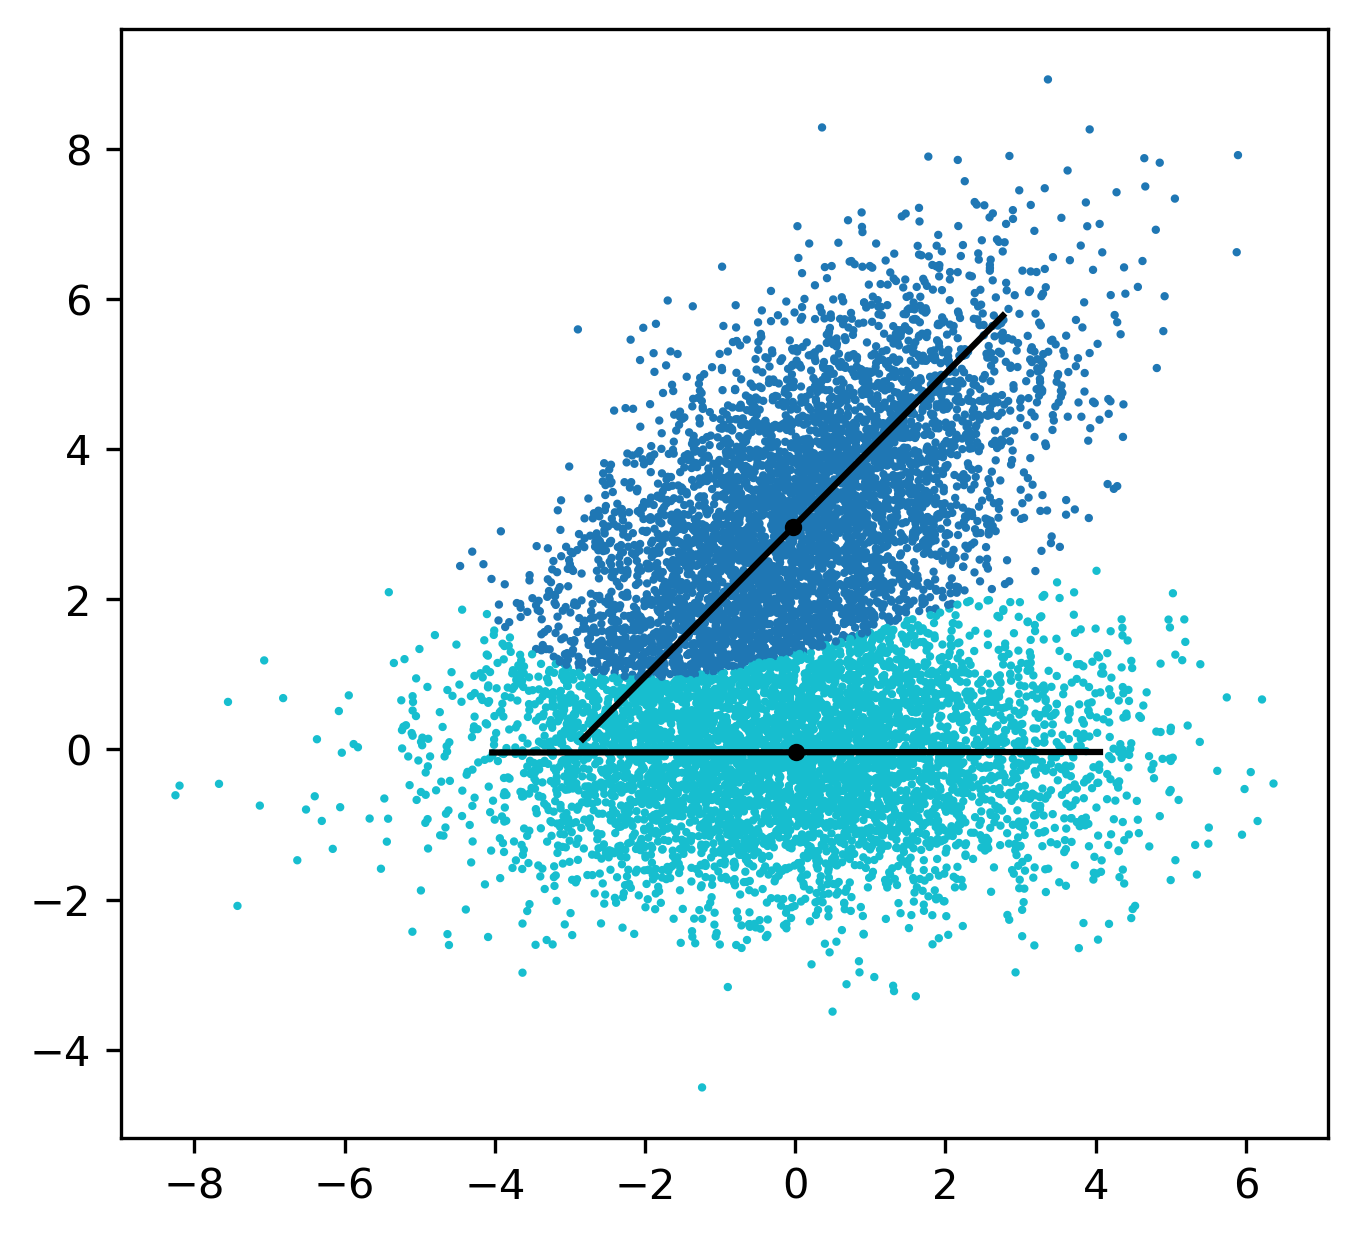

In [60]:
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1, c = np.argmax(p1, axis = 1), cmap = 'tab10')
l0 = get_line(s1[0])
ax.plot(l0[0],l0[1], c = 'black')
ax.scatter([s1[0].translation[0]],[s1[0].translation[1]], s = 10, c = 'black')

l1 = get_line(s1[1])
ax.plot(l1[0],l1[1], c = 'black')
ax.scatter([s1[1].translation[0]],[s1[1].translation[1]], s = 10, c = 'black')

ax.set_aspect('equal')

In [61]:
kspaces.model_selection.model_selection(points, s1, [s0])

BIC model is lower
79715.16193374629 < 82105.20660646241


'model'

# Model selection with ICL vs BIC

Let's overlay two subspaces but give one of them a greater noise than the other. It's hard to see by eye, but there is more density near the middle than would be expected given a single Gaussian distribution.

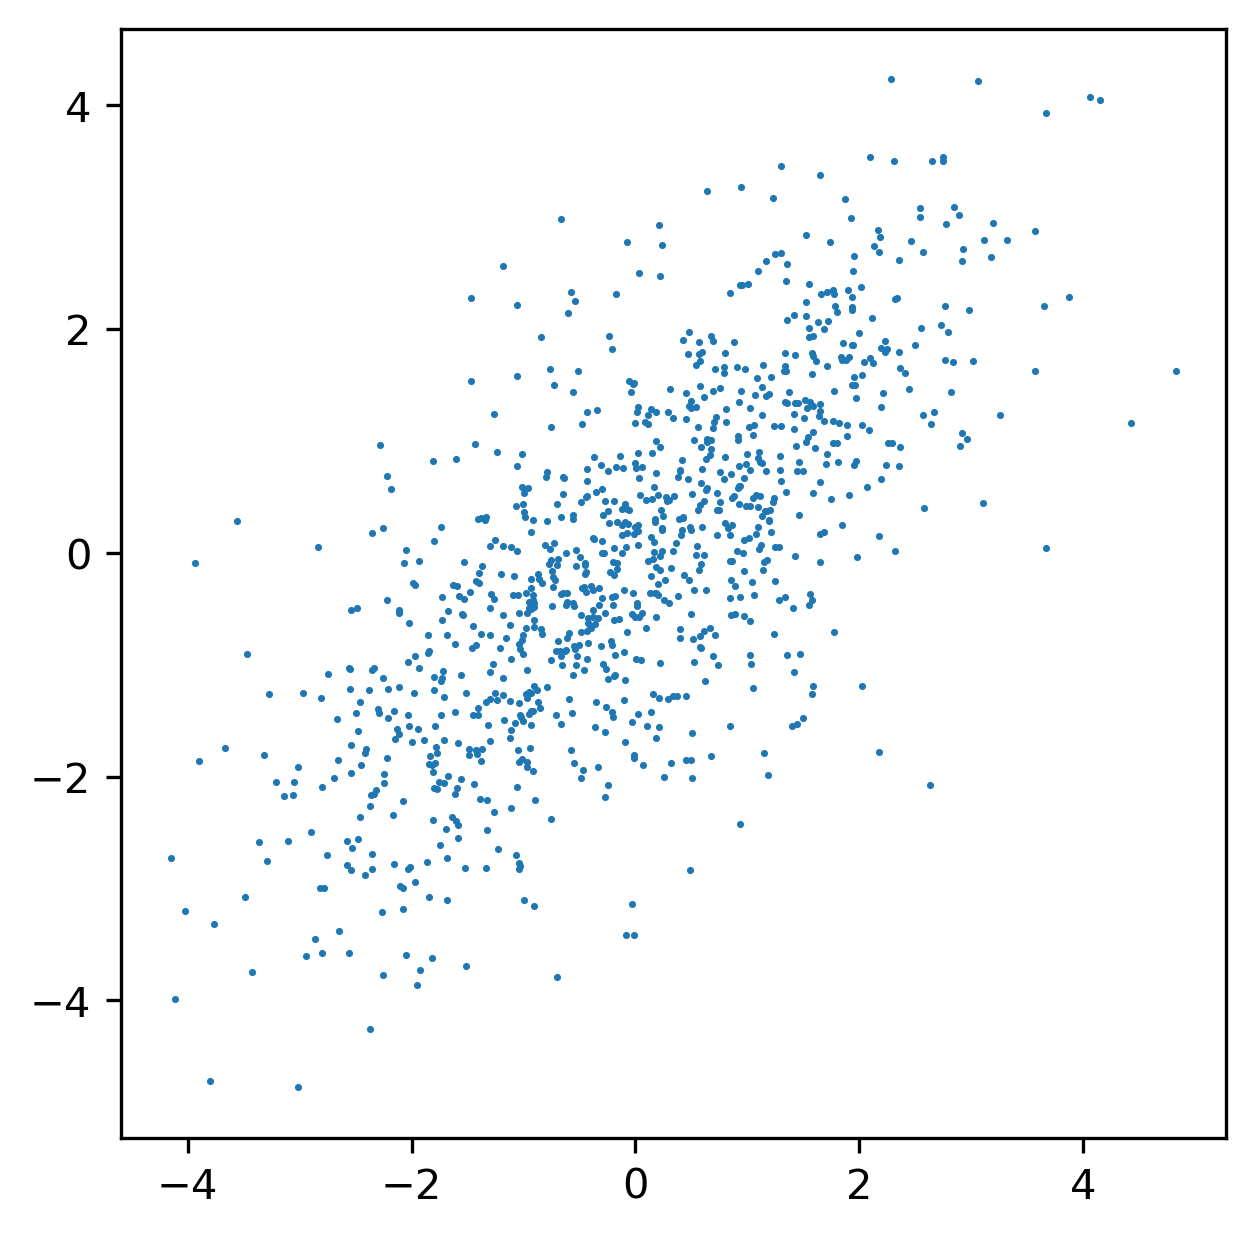

In [62]:
np.random.seed(0)
ground_truth = [kspaces.affine_subspace_.affine_subspace([[1,1]],[0,0],1,[2],0.5), kspaces.affine_subspace_.affine_subspace([[1,1]],[0,0],0.5,[2],0.5) ]
points = kspaces.generate.generate(ground_truth, size = 1000)
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 0.5)

ax.set_aspect('equal')

The subtle extra density is picked up by k-spaces (shown below) but in some clustering contexts, we want model selection to say there is 1 subspace, not 2, because the subspaces or having distinct clusters are the primary goal(s), and the probability distribution is secondary.  

max iteration 200 completed
max iteration 200 completed
max iteration 200 completed
max iteration 200 completed
Converged on iteration 45
Converged on iteration 34
max iteration 200 completed
max iteration 200 completed
max iteration 200 completed
Converged on iteration 132
time per EM run: 0.084
time per E, M step : [0.0002 0.0003]


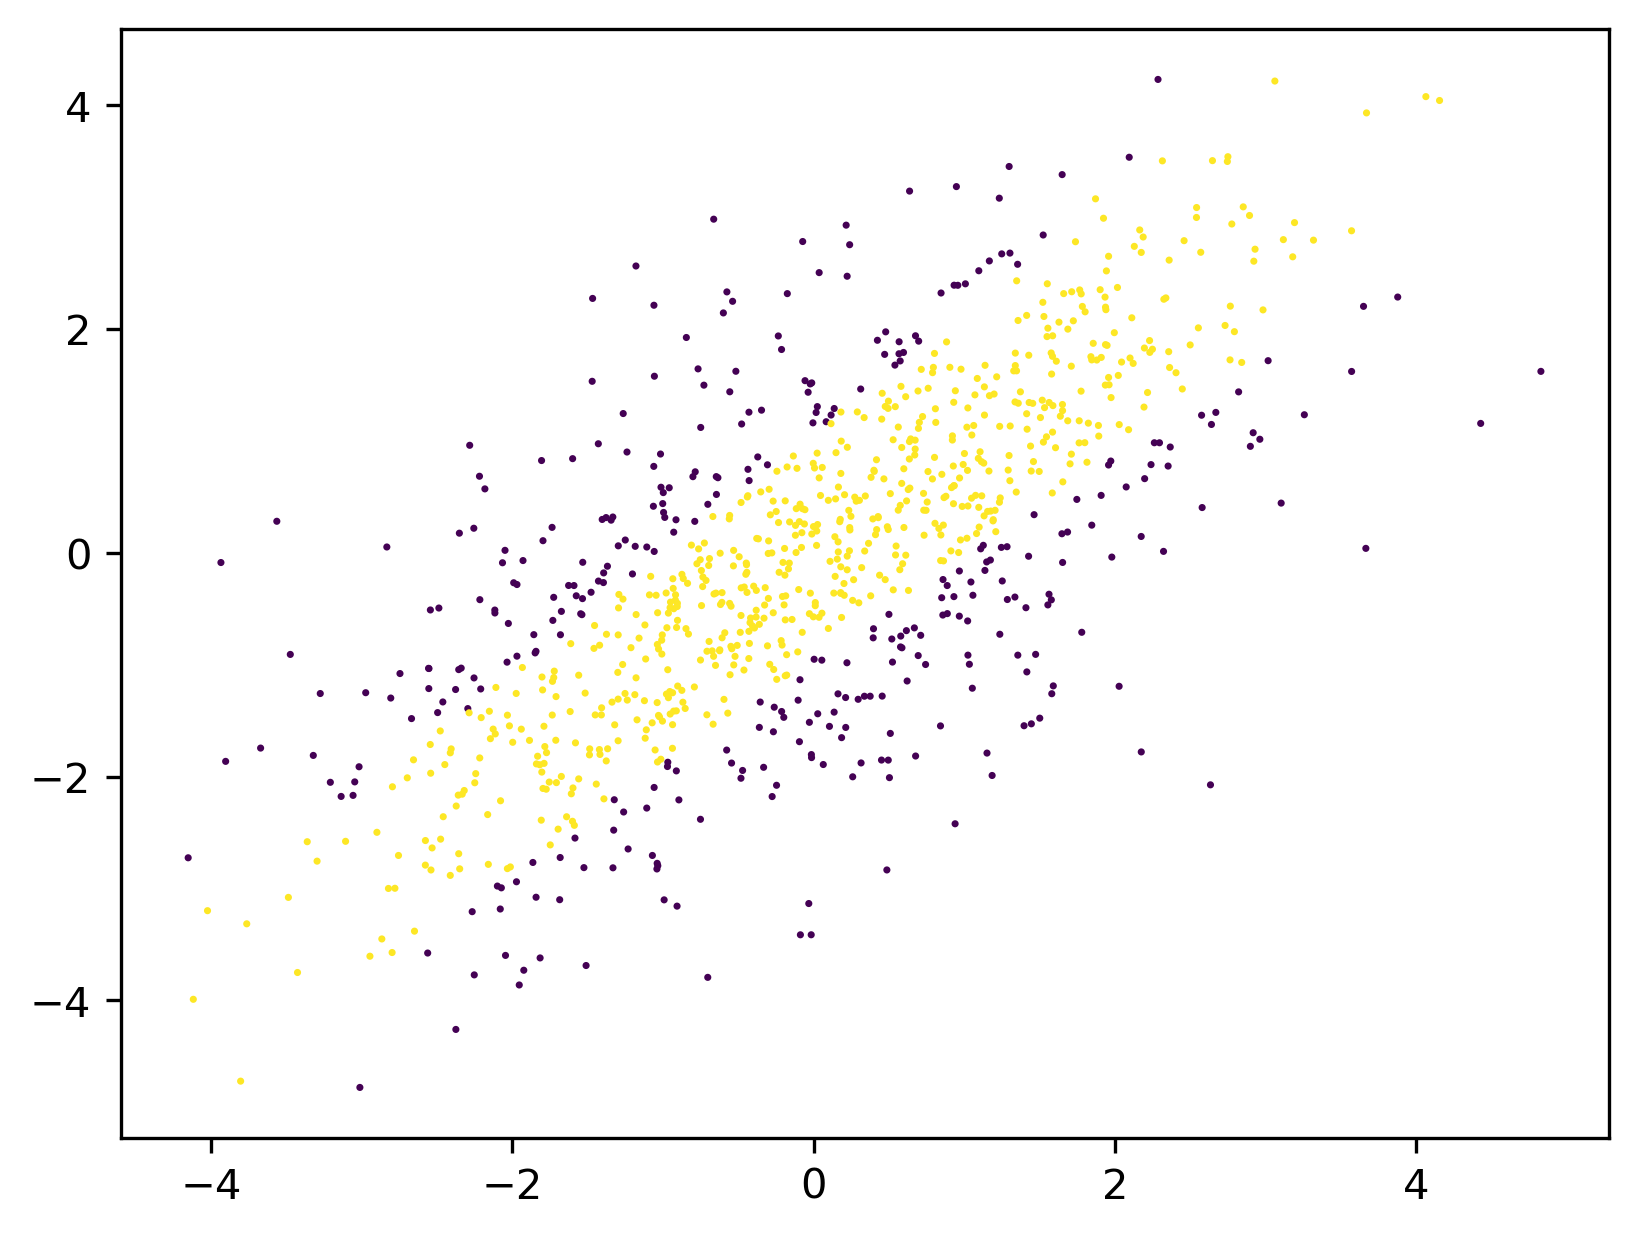

In [63]:
np.random.seed(0)
s1, p1 = kspaces.EM.run_EM(points,[1,1],assignment = 'soft', tol = 1e-5, max_iter = 200, initializations = 10)

fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 0.5, c = np.argmax(p1, axis = 1))
plt.show()

The default model selection is BIC, and it is based on the number of free parameters and the observed data likelihood (i.e., how well the probability density fits the data). It prefers the model with k = 2.

In [64]:
kspaces.model_selection.model_selection(points, s1, kspaces.EM.fit_single_space(points,1), test = 'BIC')

BIC model is not lower


'null'

One option is to use the Integrated Completed Likelihood, which penalizes for uncertainty in clustering assignments for points.

C. Biernacki, G. Celeux, and G. Govaert. Assessing a mixture model for clustering with the integrated completed likelihood. IEEE Transactions on Pattern Analysis and Machine Intelligence, 22(7):719–725, July 2000. 

In [65]:
kspaces.model_selection.model_selection(points, s1, kspaces.EM.fit_single_space(points,1), test = 'ICL')

ICL model is not lower


'null'